In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely.geometry as sg
import seaborn as sns
import ast
import folium
import os
import tensorflow as tf
from tqdm import tqdm

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Reshape, RepeatVector, TimeDistributed, Bidirectional
from keras.layers import Conv2D, Flatten, Concatenate, Input
from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Data

In [2]:
# load tacheometry in X direction
Y_x = pd.read_csv('../Data/TargetX.csv', index_col=0)

In [3]:
Y_x.shape

(5817, 42)

In [4]:
Y_y = pd.read_csv('../Data/TargetY.csv', index_col=0)

In [5]:
Y_y.shape

(5817, 42)

In [6]:
Y_z = pd.read_csv('../Data/TargetZ.csv', index_col=0)

In [8]:
# load cpt data with depth only between 7 and 11
cpt = pd.read_csv('../Data/CPT_train_v2.csv', index_col=0)

In [9]:
# only take objects that are in both dataset
Y_x = Y_x[Y_x['objectid'].isin(cpt.index)]
Y_y = Y_y[Y_y['objectid'].isin(cpt.index)]
Y_z = Y_z[Y_z['objectid'].isin(cpt.index)]

Y_x = Y_x.drop(['objectid', 'X_coordinate', 'Y_coordinate', 'segment'], axis=1)
Y_y = Y_y.drop(['objectid', 'X_coordinate', 'Y_coordinate', 'segment'], axis=1)
Y_z = Y_z.drop(['objectid', 'X_coordinate', 'Y_coordinate', 'segment'], axis=1)

In [10]:
Y_x.index.str[:7].unique()

Index(['BDG0101', 'BDG0202', 'DCG0101', 'DCG0202', 'DCG0302', 'GRW0101',
       'HEG0302', 'HEG0401', 'HEG0802', 'HEG0901', 'KVV0602', 'KVV0702',
       'KZG0301', 'KZG0302', 'LLG0102', 'LLG0202', 'LYG0501', 'LYG0601',
       'NHG0201', 'OVW0601', 'PRG0301', 'PRG0401', 'PRG0402', 'SIN0501',
       'SIN0502', 'SIN0601', 'SIN0602', 'SIN0701', 'WEG0201', 'WKN0101'],
      dtype='object')

In [11]:
sat_ver = pd.read_csv('../Data/SatVer.csv', index_col=0)

In [12]:
sat_ver.shape

(30, 38)

In [13]:
sat_hor = pd.read_csv('../Data/SatHor.csv', index_col=0)

In [14]:
sat_ach = pd.read_csv('../Data/SatAch.csv', index_col=0)

# Functions

In [15]:
def scale_features(df):
    """Scale features to be between 0 and 1"""

    df = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
    
    return df

In [16]:
def mase(y_true, y_pred):
    
    n_samples, n_timesteps = y_true.shape 
    scaling_factor = 1/(n_timesteps-1) * np.sum(np.abs(np.diff(y_true, axis=1)), axis=1)
    value = np.mean(np.abs(y_true - y_pred), axis=1) / scaling_factor
    
    return np.mean(value)

In [17]:
def create_window(df, input_width, label_width, shift, incl_cpt=False, tacheometry=True, df_cpt=None, incl_sat=False):
    """
    Create training batches of width input_width,
    and labels of width label_width
    """
    
    X = []
    X_ver = []
    X_hor = []
    X_ach = []
    Y = []

    # fix for input per measuring bolt, turns input into correct shape
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df).T
        
    # account for varying months of last measurement
    df = df.dropna()
    
    # current object
    obj = df.index.str[:7][0]
        
    for i in range(len(df.columns)):
        
        # ensure enough values are left for the label
        if i+input_width+label_width <= len(df.columns):
            
            # add window to X
            X.append(df.iloc[:,i:i+input_width].values)

            X_ver.append(train_sat_ver.loc[obj].iloc[i:i+input_width]) # remove [:,] if working with mean of sat data!
            X_hor.append(train_sat_hor.loc[obj].iloc[i:i+input_width]) # add [:,] if working without mean of sat data!
            X_ach.append(train_sat_ach.loc[obj].iloc[i:i+input_width])
            
            # add label to Y
            Y.append(df.iloc[:,i+input_width:i+input_width+label_width].values)
    
    # shape (batch, time, features)
    X = np.array(X).reshape((len(X), input_width, df.shape[0]))
    Y = np.array(Y).reshape((len(X), label_width, df.shape[0]))

    X_ver = np.expand_dims(np.array(X_ver), axis=2) # <- do this when working with mean of sat data
    X_hor = np.expand_dims(np.array(X_hor), axis=2)
    X_ach = np.expand_dims(np.array(X_ach), axis=2)

#     X_ver = np.array(X_ver).reshape((len(X), input_width, sat_ver.shape[0])) <- do this when not working with mean sat
#     X_hor = np.array(X_hor).reshape((len(X), input_width, sat_hor.shape[0]))
    
    X_ver = np.array(X_ver).reshape((len(X), input_width, 1))
    X_hor = np.array(X_hor).reshape((len(X), input_width, 1))
    X_ach = np.array(X_ach).reshape((len(X), input_width, 1))
    
    # only add cpt features if cpt data is passed
    if incl_cpt == True:

        cpt_array = np.array(df_cpt.values).reshape((1, 1, df_cpt.size))
        cpt_array = np.repeat(cpt_array, input_width, axis=1)
        cpt_array = np.repeat(cpt_array, len(X), axis=0)
        
        if tacheometry == False:
            X = cpt_array
        
        else:
            X = np.concatenate((X, cpt_array), axis=2)
            
    if incl_sat == True:
        
        X_sat = np.concatenate((X_ver, X_hor), axis=2)
        X_sat = np.concatenate((X_sat, X_ach), axis=2)
        
        if incl_cpt == False and tacheometry == False:
            X = X_sat
            
        else:
            X = np.concatenate((X, X_sat), axis=2)
              
    return X, Y

In [18]:
def create_validation_set(X, Y, splits=4):
    """
    Takes windowed training set as input,
    Splits off validation set, size equals number of splits
    """
    
    # take first windows as training set
    X_train = X[:X.shape[0]-splits]
    Y_train = Y[:Y.shape[0]-splits]
    
    # take last windows as validation set
    X_val = X[X.shape[0]-splits:]
    Y_val = Y[Y.shape[0]-splits:]
    
    return X_train, Y_train, X_val, Y_val

In [19]:
def NaiveBaseline(X, Y):
    """
    Create baseline prediction with naive method.
    Gives the last value as prediction
    """

    # predict last 5 elements of X window
    Y_pred = X[:,-6:-1,0]
    
    # compare against the 5 Y values in label
    Y_act = Y[:,:,0]
    
    # return mae and rmse
    return mean_squared_error(Y_act, Y_pred, squared=False), mean_absolute_error(Y_act, Y_pred), mase(Y_act, Y_pred)

In [20]:
def train_objects(df, input_width, label_width, shift, epochs=100, incl_cpt=True, tacheometry=True, incl_sat=False, model=None):
    """
    Train models per object, making use of create_window().
    Possible with or without features, choice of model can be passed.
    """

    results = []
    models = []
        
    # iterate over objects
    for obj in tqdm(df.index.str[:7].unique()):
        
        if incl_cpt == True:
            X, Y = create_window(df[df.index.str.contains(obj)], input_width=input_width, label_width=label_width, \
                shift=shift, incl_cpt=incl_cpt, tacheometry=tacheometry, incl_sat=incl_sat, df_cpt=cpt[cpt.index.str.contains(obj)])
        
        if incl_cpt == False:
            X, Y = create_window(df[df.index.str.contains(obj)], input_width=input_width, label_width=label_width, \
                shift=shift, incl_cpt=False, tacheometry=tacheometry, incl_sat=incl_sat)

        train_X, train_Y, val_X, val_Y = create_validation_set(X, Y)
                
        # if 'naive' is passed as model, naive model is stored in results
        if model == "naive":
            results.append(NaiveBaseline(val_X, val_Y))
            
        # otherwise, BiLSTM model is trained and stored in results
        else:
            model = initiate_model(label_width, output_length=Y.shape[2])
            results.append(model.fit(train_X, train_Y, validation_data=(val_X, val_Y), epochs=epochs, verbose=0, callbacks=[EarlyStopping(monitor='val_mean_absolute_error', patience=20, restore_best_weights=True)]))
            models.append(model)
        
    return models, results

In [21]:
def initiate_model(label_width, output_length):
    """
    Initiate and compile model
    """
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation = 'relu')))
    model.add(Reshape((1, -1)))    
    model.add(Dense(units=label_width * output_length))
    model.add(Reshape((label_width, output_length)))  
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), \
                                                        tf.keras.metrics.MeanAbsolutePercentageError()])
    return model

In [22]:
# train tcmt only on data per bout, grouped per rak, grouped per wall
def grouping_experiment(df, group, features=False):
    """
    variable group should have value 'wall', 'rak', or 'total'
    """
    
    results = []

    if group == 'total':
        X, Y = create_window(df, input_width=10, label_width=5, shift=1)
        
        train_X, train_Y, val_X, val_Y = create_validation_set(X, Y)
        model = initiate_model(5, X.shape[2])
        results.append(model.fit(train_X, train_Y, validation_data=(val_X, val_Y), epochs=100, verbose=1))
        
        return model, results
        
    else:
        if group == 'rak':
            objects = df.index.str[:7].unique()
        elif group == 'wall':
            objects = df.index.str[:3].unique()
   
        for obj in tqdm(objects):

            if features == True:
                X, Y = create_window(df[df.index.str.contains(obj)], input_width=10, label_width=5, shift=1, features=True, df_cpt=train_cpt[cpt.index.str.contains(obj)].iloc[0])
            else:
                X, Y = create_window(df[df.index.str.contains(obj)], input_width=10, label_width=5, shift=1)

            train_X, train_Y, val_X, val_Y = create_validation_set(X, Y)
            model = initiate_model(5, X.shape[2])
            results.append(model.fit(train_X, train_Y, validation_data=(val_X, val_Y), epochs=100, verbose=0, \
                                     callbacks=[EarlyStopping(monitor='val_mean_absolute_error', patience=10, restore_best_weights=True)]))    

    return results

In [23]:
def initiate_incremental(input_shape_bilstm, input_shape_new_data, label_width, outcome_length):
    """
    This function initiates and compiles an incrementally fused model
    """
    
    # Create BiLSTM model
    input_bilstm = Input(shape=input_shape_bilstm)
    bilstm = Bidirectional(LSTM(units=64, return_sequences=True))(input_bilstm)
    model_bilstm = Model(inputs=input_bilstm, outputs=bilstm)

    # Create layer for new data
    input_new_data = Input(shape=input_shape_new_data)
    new_data = Dense(units=128)(input_new_data)
    model_new_data = Model(inputs=input_new_data, outputs=new_data)

    # Concatenate BiLSTM output and new data
    merged_model = Concatenate()([model_bilstm.output, model_new_data.output])

    # Add fully connected layer
    merged_model = Dense(units=256, activation='relu')(merged_model)
    
    # Add BiLSTM layer
    merged_model = Bidirectional(LSTM(units=64, return_sequences=True))(merged_model)
    
    # Output layer
    merged_model = Reshape((1, -1))(merged_model)
    merged_model = Dense(units=label_width * outcome_length)(merged_model)
    merged_model = Reshape((label_width, outcome_length))(merged_model)

    # Create the final model
    model = Model(inputs=[model_bilstm.input, model_new_data.input], outputs=merged_model)

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

    return model

In [24]:
def incremental_fusion(first_dataset, direction, tacheometry=False):
    """
    This function yields an incrementally fused model.
    """
    
    results_inc = []
    models_inc = []
    
    # set df to corresponding direction
    if direction == 'X':
        df = train_Yx
    if direction == 'Y':
        df = train_Yy
    if direction == 'Z':
        df = train_Yz
        
    # define whether tacheometry data should be added to the windows or not
    sat_tcmt = False
    cpt_tcmt = False
    if tacheometry == True:
        if first_dataset == 'CPT':
            cpt_tcmt = True
        else:
            sat_tcmt = True
        
    # iterate over objects
    for obj in tqdm(df.index.str[:7].unique()):
        
        # create windows for satellite data
        X_sat, Y_sat = create_window(df[df.index.str.contains(obj)], input_width=10, label_width=5, \
            shift=1, incl_cpt=False, tacheometry=sat_tcmt, incl_sat=True)

        # create windows for CPT data
        X_cpt, Y_cpt = create_window(df[df.index.str.contains(obj)], input_width=10, label_width=5, \
            shift=1, incl_cpt=True, tacheometry=cpt_tcmt, incl_sat=False, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])

        # create validation set
        train_X_sat, train_Y_sat, val_X_sat, val_Y_sat = create_validation_set(X_sat, Y_sat)
        train_X_cpt, train_Y_cpt, val_X_cpt, val_Y_cpt = create_validation_set(X_cpt, Y_cpt)
                
        label_width=Y_sat.shape[1]
        outcome_length=Y_sat.shape[2]
                    
        # pass CPT as first dataset
        if first_dataset == 'CPT':
            model = initiate_incremental(train_X_cpt.shape[1:], train_X_sat.shape[1:], label_width, outcome_length)
            results_inc.append(model.fit([train_X_cpt, train_X_sat], train_Y_sat, validation_data=([val_X_cpt, val_X_sat], \
                            val_Y_sat), epochs=100, verbose=0, callbacks=[EarlyStopping(monitor='val_mean_absolute_error', patience=20, restore_best_weights=True)]))
            models_inc.append(model)
            
        # pass Sat as first dataset
        else:
            model = initiate_incremental(train_X_sat.shape[1:], train_X_cpt.shape[1:], label_width, outcome_length)
            results_inc.append(model.fit([train_X_sat, train_X_cpt], train_Y_sat, validation_data=([val_X_sat, val_X_cpt], \
                            val_Y_sat), epochs=100, verbose=0, callbacks=[EarlyStopping(monitor='val_mean_absolute_error', patience=20, restore_best_weights=True)]))
            models_inc.append(model)
            
    return models_inc, results_inc

In [25]:
def visualize_performance(results):
    """
    Visualizes the MAE and RMSE per epoch given a list of results
    """
    
    maes_train = []
    maes_val = []
    rmse_train = []
    rmse_val = []

    for i, result in enumerate(results):
        
        print(np.min(np.array(result.history['val_mean_absolute_error'])))
        
        # store MAE
        if 'val_mean_absolute_error' in result.history.keys():
            maes_train.append(result.history['mean_absolute_error'])
            maes_val.append(result.history['val_mean_absolute_error'])
            
        # store RMSE
        if 'val_root_mean_squared_error' in result.history.keys():
            rmse_train.append(result.history['root_mean_squared_error'])
            rmse_val.append(result.history['val_root_mean_squared_error'])
            
    # calculate mean values
    mean_mae_train = np.mean(np.array(maes_train), axis=0)
    mean_mae_val = np.mean(np.array(maes_val), axis=0)
    mean_rmse_train = np.mean(np.array(rmse_train), axis=0)
    mean_rmse_val = np.mean(np.array(rmse_val), axis=0)
            
    print(f'Optimal Mean MAE: {np.min(mean_mae_val)} @ epoch {np.argmin(mean_mae_val)}')
    print(f'Optimal Mean RMSE: {np.min(mean_rmse_val)} @ epoch {np.argmin(mean_rmse_val)}')
    
    # plot MAE scores
    sns.lineplot(data=mean_mae_train, label='train')
    sns.lineplot(data=mean_mae_val, label='validation')
    plt.title('Mean MAE scores of BiLSTM model')
    plt.ylabel('MAE')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # plot RMSE scores
    sns.lineplot(data=mean_rmse_train, label='train')
    sns.lineplot(data=mean_rmse_val, label='validation')
    plt.title('Mean RMSE scores of BiLSTM model')
    plt.ylabel('RMSE')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    
    return

In [26]:
def val_metrics(direction, models, input_width, label_width, shift, incl_cpt=False, incl_sat=False, tacheometry=False, incremental=False, incremental_first='CPT'):
    
    # set df to corresponding direction
    if direction == 'X':
        df = train_Yx
                
    if direction == 'Y':
        df = train_Yy
        
    if direction == 'Z':
        df = train_Yz
        
    val_rmse = []
    val_mae = []
    val_mase = []
    val_r2 = []
    
    for i, obj in enumerate(df.index.str[:7].unique()):

        X, Y = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=incl_cpt, \
                                     incl_sat=incl_sat, tacheometry=tacheometry, df_cpt=cpt[cpt.index.str.contains(obj)])
        train_X, train_Y, val_X, val_Y = create_validation_set(X, Y)
        
        model = models[i]

        if incremental == True:

            X_cpt2, Y_cpt2 = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=True, \
                                           tacheometry=False, df_cpt=cpt[cpt.index.str.contains(obj)])
            train_X_cpt2, train_Y_cpt2, val_X_cpt2, val_Y_cpt2 = create_validation_set(X_cpt2, Y_cpt2)           

            X_sat2, Y_sat2 = create_window(df[df.index.str.contains(obj)], input_width, label_width, shift, incl_cpt=False, \
                                           tacheometry=False, incl_sat=True)
            train_X_sat2, train_Y_sat2, val_X_sat2, val_Y_sat2 = create_validation_set(X_sat2, Y_sat2)
        
            if incremental_first == 'CPT':
                predictions = model.predict([val_X, val_X_sat2])
            else:
                predictions = model.predict([val_X, val_X_cpt2])
                
        else:
            predictions = model.predict(val_X)
        
        rmses = []
        maes = []
        mases = []
        r2s = []

        for j in range(predictions.shape[2]):
            maes.append(mean_absolute_error(val_Y[:,:,j], predictions[:,:,j]))
            mases.append(mase(val_Y[:,:,j], predictions[:,:,j]))
            r2s.append(r2_score(val_Y[:,:,j], predictions[:,:,j]))

            y_act = tf.constant(val_Y[:,:,j])
            y_pred = tf.constant(predictions[:,:,j])
            
            rmse = tf.keras.metrics.RootMeanSquaredError()
            rmse_value = rmse(y_act, y_pred).numpy()
            rmses.append(rmse_value)

        val_rmse.append(np.mean(rmses))
        val_mae.append(np.mean(maes))
        val_mase.append(np.mean(mases))
        val_r2.append(np.mean(r2s))
        
    return np.mean(val_rmse), np.mean(val_mae), np.mean(val_mase), np.mean(val_r2)

In [27]:
def save_models(results, combi, direction):
    """
    Save models
    """
    for i, mod in tqdm(enumerate(results[0])):
        obj = train_Yx.index.str[:7].unique()[i]
        mod.save(f'../Models/{combi}/{direction}/{obj}')
        
    return 'Models are saved successfully.'

In [28]:
def load_models(combi, direction):
    """
    Load models
    """
    models = []
    directory = f'../Models/{combi}/{direction}'
    
    for file in tqdm(os.listdir(directory)):
        models.append(tf.keras.models.load_model(f'{directory}/{file}'))

    return models

In [29]:
def late_fusion(direction, tacheometry=False, incremental=False):

    # set df to corresponding direction
    if direction == 'X':
        df = train_Yx
        if tacheometry == False:
            if incremental == False:
                models1 = results_cpt_x[0]
                models2 = results_sat_x[0]
            else:
                models1 = results_inc_cpt_sat_x[0]
                models2 = results_inc_sat_cpt_x[0]
        else:
            if incremental == False:
                models1 = results_tcmt_cpt_x[0]
                models2 = results_tcmt_sat_x[0]
            else:
                models1 = results_inc_tcmt_cpt_sat_x[0]
                models2 = results_inc_tcmt_sat_cpt_x[0]   
                
    if direction == 'Y':
        df = train_Yy
        if tacheometry == False:
            if incremental == False:
                models1 = results_cpt_y[0]
                models2 = results_sat_y[0]
            else:
                models1 = results_inc_cpt_sat_y[0]
                models2 = results_inc_sat_cpt_y[0]
        else:
            if incremental == False:
                models1 = results_tcmt_cpt_y[0]
                models2 = results_tcmt_sat_y[0]
            else:
                models1 = results_inc_tcmt_cpt_sat_y[0]
                models2 = results_inc_tcmt_sat_cpt_y[0]
                
    if direction == 'Z':
        df = train_Yz
        if tacheometry == False:
            if incremental == False:
                models1 = results_cpt_z[0]
                models2 = results_sat_z[0]
            else:
                models1 = results_inc_cpt_sat_z[0]
                models2 = results_inc_sat_cpt_z[0]
        else:
            if incremental == False:
                models1 = results_tcmt_cpt_z[0]
                models2 = results_tcmt_sat_z[0]
            else:
                models1 = results_inc_tcmt_cpt_sat_z[0]
                models2 = results_inc_tcmt_sat_cpt_z[0] 

    val_mae = []
    val_rmse = []
    val_mase = []

    for i, obj in enumerate(df.index.str[:7].unique()):

        X_cpt, Y_cpt = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=True, tacheometry=tacheometry, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])
        train_X_cpt, train_Y_cpt, val_X_cpt, val_Y_cpt = create_validation_set(X_cpt, Y_cpt)

        X_sat, Y_sat = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=False, tacheometry=tacheometry, incl_sat=True)
        train_X_sat, train_Y_sat, val_X_sat, val_Y_sat = create_validation_set(X_sat, Y_sat)

        model1 = models1[i]
        model2 = models2[i]

        
        if incremental == True:
            
            X_cpt2, Y_cpt2 = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=True, tacheometry=False, df_cpt=cpt[cpt.index.str.contains(obj)].iloc[0])
            train_X_cpt2, train_Y_cpt2, val_X_cpt2, val_Y_cpt2 = create_validation_set(X_cpt2, Y_cpt2)           
        
            X_sat2, Y_sat2 = create_window(df[df.index.str.contains(obj)], 10, 5, 1, incl_cpt=False, tacheometry=False, incl_sat=True)
            train_X_sat2, train_Y_sat2, val_X_sat2, val_Y_sat2 = create_validation_set(X_sat2, Y_sat2)
            
            predictions1 = model1.predict([val_X_cpt, val_X_sat2])
            predictions2 = model2.predict([val_X_sat, val_X_cpt2])
        else:
            predictions1 = model1.predict(val_X_cpt)
            predictions2 = model2.predict(val_X_sat)

        predictions = (predictions1 + predictions2) / 2

        maes = []
        rmses = []
        mases = []

        for j in range(predictions.shape[2]):
            maes.append(mean_absolute_error(val_Y_cpt[:,:,j], predictions[:,:,j]))
            mases.append(mase(val_Y_cpt[:,:,j], predictions[:,:,j]))

            y_act = tf.constant(val_Y_cpt[:,:,j])
            y_pred = tf.constant(predictions[:,:,j])
            rmse = tf.keras.metrics.RootMeanSquaredError()
            rmse_value = rmse(y_act, y_pred).numpy()
            rmses.append(rmse_value)

        val_mae.append(np.mean(maes))
        val_rmse.append(np.mean(rmses))
        val_mase.append(np.mean(mases))

    return np.mean(val_rmse), np.mean(val_mae), np.mean(val_mase)

# Train/Val/Test split

In [30]:
# set random seeds for reproducable results
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
cpt = scale_features(cpt)

In [33]:
# Train on 70% of the objects and 75% of the timeseries
train_Yx = Y_x[0:int(0.7*len(Y_x))].iloc[:, 0:int(0.75*len(Y_x.columns))]
train_Yy = Y_y[0:int(0.7*len(Y_y))].iloc[:, 0:int(0.75*len(Y_y.columns))]
train_Yz = Y_z[0:int(0.7*len(Y_z))].iloc[:, 0:int(0.75*len(Y_z.columns))]

# test on 70% of the objects and 75% of the timeseries
test_Yx = Y_x[0:int(0.7*len(Y_x))].iloc[:, int(0.75*len(Y_x.columns)):]

# test on 30% of the object later

In [34]:
train_Yx.shape

(1163, 28)

In [35]:
len(train_Yx.index.str[:7].unique())

20

In [36]:
train_sat_ver = sat_ver.iloc[:, 0:int(0.75*len(sat_ver.columns))]
train_sat_hor = sat_hor.iloc[:, 0:int(0.75*len(sat_hor.columns))]
train_sat_ach = sat_ach.iloc[:, 0:int(0.75*len(sat_ach.columns))]

train_sat_ver.shape, train_sat_hor.shape, train_sat_ach.shape

((30, 28), (30, 28), (30, 28))

In [37]:
X0, Y0 = create_window(train_Yx.iloc[0], input_width=10, label_width=5, shift=1, incl_cpt=True, df_cpt=cpt)

In [38]:
train_X0, train_Y0, val_X0, val_Y0 = create_validation_set(X0, Y0)

In [39]:
train_X0.shape, train_Y0.shape, val_X0.shape, val_Y0.shape

((10, 10, 511), (10, 5, 1), (4, 10, 511), (4, 5, 1))

# Check if everything works

In [220]:
model = initiate_model(5, output_length=val_Y0.shape[2])

In [221]:
result = model.fit(train_X0, train_Y0, validation_data=(val_X0, val_Y0), epochs=100, verbose=1, callbacks=[EarlyStopping(monitor='val_mean_absolute_error', patience=20, restore_best_weights=True)])

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 1.2722 - mean_absolute_error: 1.0351 - root_mean_squared_error: 1.1279 - mean_absolute_percentage_error: 105.1333 - val_loss: 2.2287 - val_mean_absolute_error: 1.3243 - val_root_mean_squared_error: 1.4929 - val_mean_absolute_percentage_error: 72.8774
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 0.4039 - mean_absolute_error: 0.5701 - root_mean_squared_error: 0.6355 - mean_absolute_percentage_error: 56.9370 - val_loss: 0.9524 - val_mean_absolute_error: 0.8117 - val_root_mean_squared_error: 0.9759 - val_mean_absolute_percentage_error: 42.1109
Epoch 3/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0567 - mean_absolute_error: 0.1958 - root_mean_squared_error: 0.2381 - mean_absolute_percentage_error: 20.0440 - val_loss: 0.3436 - val_mean_absolute_error: 0.4596 - val_root_mean_squared_error: 0.5861 - val_mean_absolute_percentage_error: 25.1105
Epoch 4/100
1/1 [==================

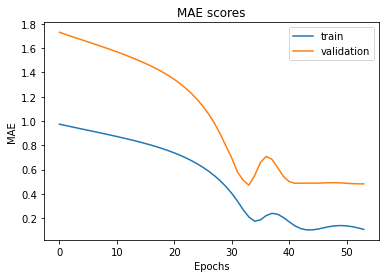

In [221]:
sns.lineplot(data=result.history['mean_absolute_error'], label='train')
sns.lineplot(data=result.history['val_mean_absolute_error'], label='validation')
plt.title('MAE scores')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Experiments

### Training per wall/rak/bout

In [37]:
results_rak = grouping_experiment(train_Yx, 'rak')
results_wall = grouping_experiment(train_Yx, 'wall')
results_total = grouping_experiment(train_Yx, 'total')

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 6.7530 - mean_absolute_error: 1.9290 - root_mean_squared_error: 2.5986 - val_loss: 11.6449 - val_mean_absolute_error: 2.7728 - val_root_mean_squared_error: 3.4125
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 6.5130 - mean_absolute_error: 1.8837 - root_mean_squared_error: 2.5520 - val_loss: 11.3141 - val_mean_absolute_error: 2.7276 - val_root_mean_squared_error: 3.3636
Epoch 3/100
1/1 [==============================] - 0s 38ms/step - loss: 6.2872 - mean_absolute_error: 1.8395 - root_mean_squared_error: 2.5074 - val_loss: 11.0073 - val_mean_absolute_error: 2.6857 - val_root_mean_squared_error: 3.3177
Epoch 4/100
1/1 [==============================] - 0s 33ms/step - loss: 6.0659 - mean_absolute_error: 1.7951 - root_mean_squared_error: 2.4629 - val_loss: 10.7074 - val_mean_absolute_error: 2.6452 - val_root_mean_squared_error: 3.2722
Epoch 5/100
1/1 [==============================] - 0s 32ms/ste

Epoch 36/100
1/1 [==============================] - 0s 34ms/step - loss: 0.7887 - mean_absolute_error: 0.5802 - root_mean_squared_error: 0.8881 - val_loss: 14.6681 - val_mean_absolute_error: 2.6031 - val_root_mean_squared_error: 3.8299
Epoch 37/100
1/1 [==============================] - 0s 37ms/step - loss: 0.7570 - mean_absolute_error: 0.5658 - root_mean_squared_error: 0.8700 - val_loss: 14.4286 - val_mean_absolute_error: 2.5858 - val_root_mean_squared_error: 3.7985
Epoch 38/100
1/1 [==============================] - 0s 29ms/step - loss: 0.7260 - mean_absolute_error: 0.5514 - root_mean_squared_error: 0.8520 - val_loss: 14.2889 - val_mean_absolute_error: 2.5733 - val_root_mean_squared_error: 3.7801
Epoch 39/100
1/1 [==============================] - 0s 39ms/step - loss: 0.6967 - mean_absolute_error: 0.5382 - root_mean_squared_error: 0.8347 - val_loss: 14.2690 - val_mean_absolute_error: 2.5673 - val_root_mean_squared_error: 3.7774
Epoch 40/100
1/1 [==============================] - 0s 3

Epoch 71/100
1/1 [==============================] - 0s 46ms/step - loss: 0.2648 - mean_absolute_error: 0.2753 - root_mean_squared_error: 0.5146 - val_loss: 10.4850 - val_mean_absolute_error: 2.1802 - val_root_mean_squared_error: 3.2381
Epoch 72/100
1/1 [==============================] - 0s 46ms/step - loss: 0.2602 - mean_absolute_error: 0.2716 - root_mean_squared_error: 0.5101 - val_loss: 10.4625 - val_mean_absolute_error: 2.1775 - val_root_mean_squared_error: 3.2346
Epoch 73/100
1/1 [==============================] - 0s 44ms/step - loss: 0.2558 - mean_absolute_error: 0.2685 - root_mean_squared_error: 0.5057 - val_loss: 10.4708 - val_mean_absolute_error: 2.1775 - val_root_mean_squared_error: 3.2359
Epoch 74/100
1/1 [==============================] - 0s 41ms/step - loss: 0.2514 - mean_absolute_error: 0.2659 - root_mean_squared_error: 0.5014 - val_loss: 10.4869 - val_mean_absolute_error: 2.1785 - val_root_mean_squared_error: 3.2383
Epoch 75/100
1/1 [==============================] - 0s 4

  5%|████▏                                                                              | 1/20 [00:07<02:23,  7.54s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.2572 - mean_absolute_error: 0.8397 - root_mean_squared_error: 1.1212 - val_loss: 2.3720 - val_mean_absolute_error: 1.1625 - val_root_mean_squared_error: 1.5401
Epoch 2/100
1/1 [==============================] - 0s 36ms/step - loss: 1.1890 - mean_absolute_error: 0.8086 - root_mean_squared_error: 1.0904 - val_loss: 2.2877 - val_mean_absolute_error: 1.1364 - val_root_mean_squared_error: 1.5125
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 1.1287 - mean_absolute_error: 0.7814 - root_mean_squared_error: 1.0624 - val_loss: 2.2073 - val_mean_absolute_error: 1.1107 - val_root_mean_squared_error: 1.4857
Epoch 4/100
1/1 [==============================] - 0s 41ms/step - loss: 1.0730 - mean_absolute_error: 0.7564 - root_mean_squared_error: 1.0358 - val_loss: 2.1274 - val_mean_absolute_error: 1.0850 - val_root_mean_squared_error: 1.4586
Epoch 5/100
1/1 [==============================] - 0s 43ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0634 - mean_absolute_error: 0.1685 - root_mean_squared_error: 0.2519 - val_loss: 0.3745 - val_mean_absolute_error: 0.4334 - val_root_mean_squared_error: 0.6119
Epoch 37/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0610 - mean_absolute_error: 0.1640 - root_mean_squared_error: 0.2470 - val_loss: 0.3621 - val_mean_absolute_error: 0.4243 - val_root_mean_squared_error: 0.6018
Epoch 38/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0588 - mean_absolute_error: 0.1607 - root_mean_squared_error: 0.2424 - val_loss: 0.3505 - val_mean_absolute_error: 0.4157 - val_root_mean_squared_error: 0.5920
Epoch 39/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0566 - mean_absolute_error: 0.1577 - root_mean_squared_error: 0.2379 - val_loss: 0.3398 - val_mean_absolute_error: 0.4078 - val_root_mean_squared_error: 0.5829
Epoch 40/100
1/1 [==============================] - 0s 39ms/

Epoch 71/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0114 - mean_absolute_error: 0.0690 - root_mean_squared_error: 0.1068 - val_loss: 0.2330 - val_mean_absolute_error: 0.3096 - val_root_mean_squared_error: 0.4828
Epoch 72/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0109 - mean_absolute_error: 0.0674 - root_mean_squared_error: 0.1045 - val_loss: 0.2311 - val_mean_absolute_error: 0.3076 - val_root_mean_squared_error: 0.4807
Epoch 73/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0105 - mean_absolute_error: 0.0660 - root_mean_squared_error: 0.1023 - val_loss: 0.2292 - val_mean_absolute_error: 0.3057 - val_root_mean_squared_error: 0.4788
Epoch 74/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0101 - mean_absolute_error: 0.0646 - root_mean_squared_error: 0.1003 - val_loss: 0.2275 - val_mean_absolute_error: 0.3038 - val_root_mean_squared_error: 0.4770
Epoch 75/100
1/1 [==============================] - 0s 39ms/

 10%|████████▎                                                                          | 2/20 [00:15<02:16,  7.57s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 2.0750 - mean_absolute_error: 1.0730 - root_mean_squared_error: 1.4405 - val_loss: 2.0656 - val_mean_absolute_error: 1.1523 - val_root_mean_squared_error: 1.4372
Epoch 2/100
1/1 [==============================] - 0s 36ms/step - loss: 1.9607 - mean_absolute_error: 1.0291 - root_mean_squared_error: 1.4003 - val_loss: 1.9518 - val_mean_absolute_error: 1.1145 - val_root_mean_squared_error: 1.3971
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 1.8532 - mean_absolute_error: 0.9867 - root_mean_squared_error: 1.3613 - val_loss: 1.8421 - val_mean_absolute_error: 1.0779 - val_root_mean_squared_error: 1.3572
Epoch 4/100
1/1 [==============================] - 0s 36ms/step - loss: 1.7488 - mean_absolute_error: 0.9456 - root_mean_squared_error: 1.3224 - val_loss: 1.7333 - val_mean_absolute_error: 1.0429 - val_root_mean_squared_error: 1.3165
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 41ms/step - loss: 0.1768 - mean_absolute_error: 0.2680 - root_mean_squared_error: 0.4205 - val_loss: 0.5483 - val_mean_absolute_error: 0.5671 - val_root_mean_squared_error: 0.7405
Epoch 37/100
1/1 [==============================] - 0s 44ms/step - loss: 0.1699 - mean_absolute_error: 0.2634 - root_mean_squared_error: 0.4122 - val_loss: 0.5474 - val_mean_absolute_error: 0.5691 - val_root_mean_squared_error: 0.7399
Epoch 38/100
1/1 [==============================] - 0s 43ms/step - loss: 0.1635 - mean_absolute_error: 0.2592 - root_mean_squared_error: 0.4043 - val_loss: 0.5463 - val_mean_absolute_error: 0.5712 - val_root_mean_squared_error: 0.7391
Epoch 39/100
1/1 [==============================] - 0s 42ms/step - loss: 0.1574 - mean_absolute_error: 0.2553 - root_mean_squared_error: 0.3967 - val_loss: 0.5448 - val_mean_absolute_error: 0.5731 - val_root_mean_squared_error: 0.7381
Epoch 40/100
1/1 [==============================] - 0s 43ms/

Epoch 71/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0241 - mean_absolute_error: 0.1076 - root_mean_squared_error: 0.1551 - val_loss: 0.2277 - val_mean_absolute_error: 0.3381 - val_root_mean_squared_error: 0.4772
Epoch 72/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0224 - mean_absolute_error: 0.1041 - root_mean_squared_error: 0.1497 - val_loss: 0.2232 - val_mean_absolute_error: 0.3337 - val_root_mean_squared_error: 0.4724
Epoch 73/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0209 - mean_absolute_error: 0.1009 - root_mean_squared_error: 0.1446 - val_loss: 0.2191 - val_mean_absolute_error: 0.3300 - val_root_mean_squared_error: 0.4681
Epoch 74/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0195 - mean_absolute_error: 0.0977 - root_mean_squared_error: 0.1397 - val_loss: 0.2156 - val_mean_absolute_error: 0.3268 - val_root_mean_squared_error: 0.4643
Epoch 75/100
1/1 [==============================] - 0s 37ms/

 15%|████████████▍                                                                      | 3/20 [00:22<02:05,  7.37s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 2.2233 - mean_absolute_error: 0.9946 - root_mean_squared_error: 1.4911 - val_loss: 3.8413 - val_mean_absolute_error: 1.3257 - val_root_mean_squared_error: 1.9599
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 2.1648 - mean_absolute_error: 0.9725 - root_mean_squared_error: 1.4713 - val_loss: 3.7244 - val_mean_absolute_error: 1.2917 - val_root_mean_squared_error: 1.9299
Epoch 3/100
1/1 [==============================] - 0s 43ms/step - loss: 2.1086 - mean_absolute_error: 0.9517 - root_mean_squared_error: 1.4521 - val_loss: 3.6088 - val_mean_absolute_error: 1.2593 - val_root_mean_squared_error: 1.8997
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 2.0526 - mean_absolute_error: 0.9310 - root_mean_squared_error: 1.4327 - val_loss: 3.4904 - val_mean_absolute_error: 1.2261 - val_root_mean_squared_error: 1.8683
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1416 - mean_absolute_error: 0.2453 - root_mean_squared_error: 0.3763 - val_loss: 1.9891 - val_mean_absolute_error: 0.7127 - val_root_mean_squared_error: 1.4103
Epoch 37/100
1/1 [==============================] - 0s 47ms/step - loss: 0.1292 - mean_absolute_error: 0.2356 - root_mean_squared_error: 0.3595 - val_loss: 1.9028 - val_mean_absolute_error: 0.6870 - val_root_mean_squared_error: 1.3794
Epoch 38/100
1/1 [==============================] - 0s 37ms/step - loss: 0.1174 - mean_absolute_error: 0.2252 - root_mean_squared_error: 0.3426 - val_loss: 1.7809 - val_mean_absolute_error: 0.6468 - val_root_mean_squared_error: 1.3345
Epoch 39/100
1/1 [==============================] - 0s 36ms/step - loss: 0.1062 - mean_absolute_error: 0.2146 - root_mean_squared_error: 0.3259 - val_loss: 1.6542 - val_mean_absolute_error: 0.6056 - val_root_mean_squared_error: 1.2862
Epoch 40/100
1/1 [==============================] - 0s 39ms/

Epoch 71/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0056 - mean_absolute_error: 0.0548 - root_mean_squared_error: 0.0746 - val_loss: 0.7632 - val_mean_absolute_error: 0.3107 - val_root_mean_squared_error: 0.8736
Epoch 72/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0052 - mean_absolute_error: 0.0527 - root_mean_squared_error: 0.0722 - val_loss: 0.7607 - val_mean_absolute_error: 0.3079 - val_root_mean_squared_error: 0.8722
Epoch 73/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0048 - mean_absolute_error: 0.0506 - root_mean_squared_error: 0.0696 - val_loss: 0.7585 - val_mean_absolute_error: 0.3047 - val_root_mean_squared_error: 0.8709
Epoch 74/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0045 - mean_absolute_error: 0.0486 - root_mean_squared_error: 0.0672 - val_loss: 0.7569 - val_mean_absolute_error: 0.3009 - val_root_mean_squared_error: 0.8700
Epoch 75/100
1/1 [==============================] - 0s 40ms/

 20%|████████████████▌                                                                  | 4/20 [00:29<01:58,  7.38s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 4.4094 - mean_absolute_error: 1.5714 - root_mean_squared_error: 2.0999 - val_loss: 3.0756 - val_mean_absolute_error: 1.4264 - val_root_mean_squared_error: 1.7538
Epoch 2/100
1/1 [==============================] - 0s 36ms/step - loss: 4.1909 - mean_absolute_error: 1.5170 - root_mean_squared_error: 2.0472 - val_loss: 2.8683 - val_mean_absolute_error: 1.3771 - val_root_mean_squared_error: 1.6936
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 3.9986 - mean_absolute_error: 1.4687 - root_mean_squared_error: 1.9997 - val_loss: 2.6881 - val_mean_absolute_error: 1.3316 - val_root_mean_squared_error: 1.6395
Epoch 4/100
1/1 [==============================] - 0s 32ms/step - loss: 3.8191 - mean_absolute_error: 1.4236 - root_mean_squared_error: 1.9542 - val_loss: 2.5234 - val_mean_absolute_error: 1.2880 - val_root_mean_squared_error: 1.5885
Epoch 5/100
1/1 [==============================] - 0s 44ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 35ms/step - loss: 0.2740 - mean_absolute_error: 0.3671 - root_mean_squared_error: 0.5234 - val_loss: 0.9976 - val_mean_absolute_error: 0.7837 - val_root_mean_squared_error: 0.9988
Epoch 37/100
1/1 [==============================] - 0s 39ms/step - loss: 0.2514 - mean_absolute_error: 0.3567 - root_mean_squared_error: 0.5014 - val_loss: 1.0139 - val_mean_absolute_error: 0.7896 - val_root_mean_squared_error: 1.0069
Epoch 38/100
1/1 [==============================] - 0s 36ms/step - loss: 0.2313 - mean_absolute_error: 0.3476 - root_mean_squared_error: 0.4810 - val_loss: 1.0338 - val_mean_absolute_error: 0.7953 - val_root_mean_squared_error: 1.0168
Epoch 39/100
1/1 [==============================] - 0s 41ms/step - loss: 0.2148 - mean_absolute_error: 0.3399 - root_mean_squared_error: 0.4634 - val_loss: 1.0509 - val_mean_absolute_error: 0.7998 - val_root_mean_squared_error: 1.0251
Epoch 40/100
1/1 [==============================] - 0s 39ms/

Epoch 71/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0390 - mean_absolute_error: 0.1306 - root_mean_squared_error: 0.1975 - val_loss: 0.5857 - val_mean_absolute_error: 0.5415 - val_root_mean_squared_error: 0.7653
Epoch 72/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0375 - mean_absolute_error: 0.1276 - root_mean_squared_error: 0.1936 - val_loss: 0.5716 - val_mean_absolute_error: 0.5341 - val_root_mean_squared_error: 0.7561
Epoch 73/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0361 - mean_absolute_error: 0.1246 - root_mean_squared_error: 0.1899 - val_loss: 0.5577 - val_mean_absolute_error: 0.5272 - val_root_mean_squared_error: 0.7468
Epoch 74/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0348 - mean_absolute_error: 0.1216 - root_mean_squared_error: 0.1865 - val_loss: 0.5444 - val_mean_absolute_error: 0.5206 - val_root_mean_squared_error: 0.7378
Epoch 75/100
1/1 [==============================] - 0s 42ms/

 25%|████████████████████▊                                                              | 5/20 [00:37<01:50,  7.37s/it]

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 1.4086 - mean_absolute_error: 0.9290 - root_mean_squared_error: 1.1868 - val_loss: 2.5614 - val_mean_absolute_error: 1.1035 - val_root_mean_squared_error: 1.6004
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 1.3253 - mean_absolute_error: 0.8920 - root_mean_squared_error: 1.1512 - val_loss: 2.4936 - val_mean_absolute_error: 1.0819 - val_root_mean_squared_error: 1.5791
Epoch 3/100
1/1 [==============================] - 0s 38ms/step - loss: 1.2480 - mean_absolute_error: 0.8568 - root_mean_squared_error: 1.1171 - val_loss: 2.4303 - val_mean_absolute_error: 1.0622 - val_root_mean_squared_error: 1.5589
Epoch 4/100
1/1 [==============================] - 0s 35ms/step - loss: 1.1740 - mean_absolute_error: 0.8224 - root_mean_squared_error: 1.0835 - val_loss: 2.3694 - val_mean_absolute_error: 1.0436 - val_root_mean_squared_error: 1.5393
Epoch 5/100
1/1 [==============================] - 0s 33ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 43ms/step - loss: 0.1301 - mean_absolute_error: 0.2449 - root_mean_squared_error: 0.3608 - val_loss: 1.6706 - val_mean_absolute_error: 0.7956 - val_root_mean_squared_error: 1.2925
Epoch 37/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1243 - mean_absolute_error: 0.2382 - root_mean_squared_error: 0.3525 - val_loss: 1.6742 - val_mean_absolute_error: 0.7950 - val_root_mean_squared_error: 1.2939
Epoch 38/100
1/1 [==============================] - 0s 41ms/step - loss: 0.1185 - mean_absolute_error: 0.2325 - root_mean_squared_error: 0.3443 - val_loss: 1.6769 - val_mean_absolute_error: 0.7946 - val_root_mean_squared_error: 1.2950
Epoch 39/100
1/1 [==============================] - 0s 41ms/step - loss: 0.1127 - mean_absolute_error: 0.2270 - root_mean_squared_error: 0.3357 - val_loss: 1.6787 - val_mean_absolute_error: 0.7942 - val_root_mean_squared_error: 1.2956
Epoch 40/100
1/1 [==============================] - 0s 37ms/

Epoch 71/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0131 - mean_absolute_error: 0.0801 - root_mean_squared_error: 0.1145 - val_loss: 1.7266 - val_mean_absolute_error: 0.7474 - val_root_mean_squared_error: 1.3140
Epoch 72/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0122 - mean_absolute_error: 0.0772 - root_mean_squared_error: 0.1104 - val_loss: 1.7250 - val_mean_absolute_error: 0.7448 - val_root_mean_squared_error: 1.3134
Epoch 73/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0114 - mean_absolute_error: 0.0744 - root_mean_squared_error: 0.1065 - val_loss: 1.7239 - val_mean_absolute_error: 0.7424 - val_root_mean_squared_error: 1.3130
Epoch 74/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0106 - mean_absolute_error: 0.0721 - root_mean_squared_error: 0.1029 - val_loss: 1.7234 - val_mean_absolute_error: 0.7401 - val_root_mean_squared_error: 1.3128
Epoch 75/100
1/1 [==============================] - 0s 39ms/

 30%|████████████████████████▉                                                          | 6/20 [00:44<01:46,  7.57s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.3749 - mean_absolute_error: 0.4669 - root_mean_squared_error: 0.6123 - val_loss: 1.2264 - val_mean_absolute_error: 0.8031 - val_root_mean_squared_error: 1.1074
Epoch 2/100
1/1 [==============================] - 0s 39ms/step - loss: 0.3634 - mean_absolute_error: 0.4586 - root_mean_squared_error: 0.6028 - val_loss: 1.2001 - val_mean_absolute_error: 0.7930 - val_root_mean_squared_error: 1.0955
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 0.3521 - mean_absolute_error: 0.4502 - root_mean_squared_error: 0.5934 - val_loss: 1.1739 - val_mean_absolute_error: 0.7827 - val_root_mean_squared_error: 1.0834
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 0.3408 - mean_absolute_error: 0.4416 - root_mean_squared_error: 0.5838 - val_loss: 1.1469 - val_mean_absolute_error: 0.7723 - val_root_mean_squared_error: 1.0709
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0946 - mean_absolute_error: 0.2237 - root_mean_squared_error: 0.3075 - val_loss: 0.4675 - val_mean_absolute_error: 0.5195 - val_root_mean_squared_error: 0.6837
Epoch 37/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0929 - mean_absolute_error: 0.2218 - root_mean_squared_error: 0.3048 - val_loss: 0.4607 - val_mean_absolute_error: 0.5148 - val_root_mean_squared_error: 0.6787
Epoch 38/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0910 - mean_absolute_error: 0.2198 - root_mean_squared_error: 0.3017 - val_loss: 0.4510 - val_mean_absolute_error: 0.5074 - val_root_mean_squared_error: 0.6715
Epoch 39/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0890 - mean_absolute_error: 0.2176 - root_mean_squared_error: 0.2983 - val_loss: 0.4395 - val_mean_absolute_error: 0.4984 - val_root_mean_squared_error: 0.6630
Epoch 40/100
1/1 [==============================] - 0s 42ms/

Epoch 71/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0316 - mean_absolute_error: 0.1161 - root_mean_squared_error: 0.1778 - val_loss: 0.3533 - val_mean_absolute_error: 0.3666 - val_root_mean_squared_error: 0.5944
Epoch 72/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0306 - mean_absolute_error: 0.1134 - root_mean_squared_error: 0.1750 - val_loss: 0.3451 - val_mean_absolute_error: 0.3622 - val_root_mean_squared_error: 0.5874
Epoch 73/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0297 - mean_absolute_error: 0.1109 - root_mean_squared_error: 0.1723 - val_loss: 0.3411 - val_mean_absolute_error: 0.3598 - val_root_mean_squared_error: 0.5840
Epoch 74/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0288 - mean_absolute_error: 0.1086 - root_mean_squared_error: 0.1697 - val_loss: 0.3382 - val_mean_absolute_error: 0.3579 - val_root_mean_squared_error: 0.5815
Epoch 75/100
1/1 [==============================] - 0s 40ms/

 35%|█████████████████████████████                                                      | 7/20 [00:52<01:37,  7.51s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.0251 - mean_absolute_error: 0.7459 - root_mean_squared_error: 1.0125 - val_loss: 1.9557 - val_mean_absolute_error: 1.0536 - val_root_mean_squared_error: 1.3985
Epoch 2/100
1/1 [==============================] - 0s 35ms/step - loss: 0.9927 - mean_absolute_error: 0.7300 - root_mean_squared_error: 0.9963 - val_loss: 1.9053 - val_mean_absolute_error: 1.0364 - val_root_mean_squared_error: 1.3803
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 0.9611 - mean_absolute_error: 0.7146 - root_mean_squared_error: 0.9803 - val_loss: 1.8566 - val_mean_absolute_error: 1.0195 - val_root_mean_squared_error: 1.3626
Epoch 4/100
1/1 [==============================] - 0s 38ms/step - loss: 0.9297 - mean_absolute_error: 0.6990 - root_mean_squared_error: 0.9642 - val_loss: 1.8085 - val_mean_absolute_error: 1.0025 - val_root_mean_squared_error: 1.3448
Epoch 5/100
1/1 [==============================] - 0s 44ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 34ms/step - loss: 0.1177 - mean_absolute_error: 0.2343 - root_mean_squared_error: 0.3431 - val_loss: 1.2715 - val_mean_absolute_error: 0.7174 - val_root_mean_squared_error: 1.1276
Epoch 37/100
1/1 [==============================] - 0s 33ms/step - loss: 0.1153 - mean_absolute_error: 0.2311 - root_mean_squared_error: 0.3396 - val_loss: 1.2326 - val_mean_absolute_error: 0.6972 - val_root_mean_squared_error: 1.1102
Epoch 38/100
1/1 [==============================] - 0s 33ms/step - loss: 0.1136 - mean_absolute_error: 0.2285 - root_mean_squared_error: 0.3370 - val_loss: 1.2044 - val_mean_absolute_error: 0.6810 - val_root_mean_squared_error: 1.0975
Epoch 39/100
1/1 [==============================] - 0s 32ms/step - loss: 0.1123 - mean_absolute_error: 0.2261 - root_mean_squared_error: 0.3351 - val_loss: 1.1865 - val_mean_absolute_error: 0.6691 - val_root_mean_squared_error: 1.0893
Epoch 40/100
1/1 [==============================] - 0s 35ms/

Epoch 71/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0849 - mean_absolute_error: 0.1825 - root_mean_squared_error: 0.2915 - val_loss: 1.0550 - val_mean_absolute_error: 0.5887 - val_root_mean_squared_error: 1.0271
Epoch 72/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0842 - mean_absolute_error: 0.1817 - root_mean_squared_error: 0.2902 - val_loss: 1.0567 - val_mean_absolute_error: 0.5899 - val_root_mean_squared_error: 1.0279
Epoch 73/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0835 - mean_absolute_error: 0.1809 - root_mean_squared_error: 0.2890 - val_loss: 1.0586 - val_mean_absolute_error: 0.5913 - val_root_mean_squared_error: 1.0289
Epoch 74/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0828 - mean_absolute_error: 0.1802 - root_mean_squared_error: 0.2877 - val_loss: 1.0600 - val_mean_absolute_error: 0.5924 - val_root_mean_squared_error: 1.0296
Epoch 75/100
1/1 [==============================] - 0s 27ms/

 40%|█████████████████████████████████▏                                                 | 8/20 [00:59<01:27,  7.29s/it]

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 4.1559 - mean_absolute_error: 1.2932 - root_mean_squared_error: 2.0386 - val_loss: 14.2317 - val_mean_absolute_error: 2.7944 - val_root_mean_squared_error: 3.7725
Epoch 2/100
1/1 [==============================] - 0s 42ms/step - loss: 4.0626 - mean_absolute_error: 1.2719 - root_mean_squared_error: 2.0156 - val_loss: 13.8998 - val_mean_absolute_error: 2.7506 - val_root_mean_squared_error: 3.7282
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 3.9675 - mean_absolute_error: 1.2500 - root_mean_squared_error: 1.9919 - val_loss: 13.5544 - val_mean_absolute_error: 2.7040 - val_root_mean_squared_error: 3.6816
Epoch 4/100
1/1 [==============================] - 0s 44ms/step - loss: 3.8656 - mean_absolute_error: 1.2266 - root_mean_squared_error: 1.9661 - val_loss: 13.1839 - val_mean_absolute_error: 2.6547 - val_root_mean_squared_error: 3.6310
Epoch 5/100
1/1 [==============================] - 0s 42ms/ste

Epoch 36/100
1/1 [==============================] - 0s 34ms/step - loss: 0.7594 - mean_absolute_error: 0.5683 - root_mean_squared_error: 0.8714 - val_loss: 7.2851 - val_mean_absolute_error: 1.9937 - val_root_mean_squared_error: 2.6991
Epoch 37/100
1/1 [==============================] - 0s 34ms/step - loss: 0.7366 - mean_absolute_error: 0.5592 - root_mean_squared_error: 0.8583 - val_loss: 7.3796 - val_mean_absolute_error: 2.0041 - val_root_mean_squared_error: 2.7165
Epoch 38/100
1/1 [==============================] - 0s 37ms/step - loss: 0.7136 - mean_absolute_error: 0.5505 - root_mean_squared_error: 0.8447 - val_loss: 7.5208 - val_mean_absolute_error: 2.0207 - val_root_mean_squared_error: 2.7424
Epoch 39/100
1/1 [==============================] - 0s 34ms/step - loss: 0.6911 - mean_absolute_error: 0.5420 - root_mean_squared_error: 0.8313 - val_loss: 7.6989 - val_mean_absolute_error: 2.0418 - val_root_mean_squared_error: 2.7747
Epoch 40/100
1/1 [==============================] - 0s 31ms/

Epoch 71/100
1/1 [==============================] - 0s 34ms/step - loss: 0.3361 - mean_absolute_error: 0.3440 - root_mean_squared_error: 0.5797 - val_loss: 9.7063 - val_mean_absolute_error: 2.2522 - val_root_mean_squared_error: 3.1155
Epoch 72/100
1/1 [==============================] - 0s 36ms/step - loss: 0.3320 - mean_absolute_error: 0.3410 - root_mean_squared_error: 0.5762 - val_loss: 9.7137 - val_mean_absolute_error: 2.2518 - val_root_mean_squared_error: 3.1167
Epoch 73/100
1/1 [==============================] - 0s 35ms/step - loss: 0.3280 - mean_absolute_error: 0.3378 - root_mean_squared_error: 0.5727 - val_loss: 9.7079 - val_mean_absolute_error: 2.2499 - val_root_mean_squared_error: 3.1158
Epoch 74/100
1/1 [==============================] - 0s 32ms/step - loss: 0.3242 - mean_absolute_error: 0.3347 - root_mean_squared_error: 0.5694 - val_loss: 9.6925 - val_mean_absolute_error: 2.2469 - val_root_mean_squared_error: 3.1133
Epoch 75/100
1/1 [==============================] - 0s 36ms/

 45%|█████████████████████████████████████▎                                             | 9/20 [01:06<01:21,  7.37s/it]

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9394 - mean_absolute_error: 0.6345 - root_mean_squared_error: 0.9692 - val_loss: 2.9280 - val_mean_absolute_error: 1.1576 - val_root_mean_squared_error: 1.7111
Epoch 2/100
1/1 [==============================] - 0s 37ms/step - loss: 0.9120 - mean_absolute_error: 0.6185 - root_mean_squared_error: 0.9550 - val_loss: 2.8752 - val_mean_absolute_error: 1.1383 - val_root_mean_squared_error: 1.6956
Epoch 3/100
1/1 [==============================] - 0s 36ms/step - loss: 0.8849 - mean_absolute_error: 0.6030 - root_mean_squared_error: 0.9407 - val_loss: 2.8212 - val_mean_absolute_error: 1.1189 - val_root_mean_squared_error: 1.6797
Epoch 4/100
1/1 [==============================] - 0s 32ms/step - loss: 0.8567 - mean_absolute_error: 0.5870 - root_mean_squared_error: 0.9256 - val_loss: 2.7637 - val_mean_absolute_error: 1.0970 - val_root_mean_squared_error: 1.6624
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0533 - mean_absolute_error: 0.1425 - root_mean_squared_error: 0.2308 - val_loss: 2.1867 - val_mean_absolute_error: 0.8105 - val_root_mean_squared_error: 1.4788
Epoch 37/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0486 - mean_absolute_error: 0.1357 - root_mean_squared_error: 0.2205 - val_loss: 2.1874 - val_mean_absolute_error: 0.8061 - val_root_mean_squared_error: 1.4790
Epoch 38/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0446 - mean_absolute_error: 0.1297 - root_mean_squared_error: 0.2111 - val_loss: 2.1805 - val_mean_absolute_error: 0.8006 - val_root_mean_squared_error: 1.4767
Epoch 39/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0410 - mean_absolute_error: 0.1249 - root_mean_squared_error: 0.2026 - val_loss: 2.1614 - val_mean_absolute_error: 0.7926 - val_root_mean_squared_error: 1.4702
Epoch 40/100
1/1 [==============================] - 0s 37ms/

Epoch 71/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0022 - mean_absolute_error: 0.0339 - root_mean_squared_error: 0.0472 - val_loss: 1.7260 - val_mean_absolute_error: 0.6110 - val_root_mean_squared_error: 1.3138
Epoch 72/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0021 - mean_absolute_error: 0.0326 - root_mean_squared_error: 0.0455 - val_loss: 1.7262 - val_mean_absolute_error: 0.6089 - val_root_mean_squared_error: 1.3138
Epoch 73/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0019 - mean_absolute_error: 0.0313 - root_mean_squared_error: 0.0439 - val_loss: 1.7259 - val_mean_absolute_error: 0.6072 - val_root_mean_squared_error: 1.3138
Epoch 74/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0018 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0424 - val_loss: 1.7252 - val_mean_absolute_error: 0.6057 - val_root_mean_squared_error: 1.3135
Epoch 75/100
1/1 [==============================] - 0s 40ms/

 50%|█████████████████████████████████████████                                         | 10/20 [01:15<01:18,  7.89s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 5.1319 - mean_absolute_error: 1.7029 - root_mean_squared_error: 2.2654 - val_loss: 8.9249 - val_mean_absolute_error: 2.2514 - val_root_mean_squared_error: 2.9875
Epoch 2/100
1/1 [==============================] - 0s 35ms/step - loss: 4.8670 - mean_absolute_error: 1.6465 - root_mean_squared_error: 2.2061 - val_loss: 8.4960 - val_mean_absolute_error: 2.1861 - val_root_mean_squared_error: 2.9148
Epoch 3/100
1/1 [==============================] - 0s 33ms/step - loss: 4.6344 - mean_absolute_error: 1.5964 - root_mean_squared_error: 2.1528 - val_loss: 8.0780 - val_mean_absolute_error: 2.1189 - val_root_mean_squared_error: 2.8422
Epoch 4/100
1/1 [==============================] - 0s 36ms/step - loss: 4.3985 - mean_absolute_error: 1.5438 - root_mean_squared_error: 2.0973 - val_loss: 7.6257 - val_mean_absolute_error: 2.0465 - val_root_mean_squared_error: 2.7615
Epoch 5/100
1/1 [==============================] - 0s 31ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 31ms/step - loss: 0.2095 - mean_absolute_error: 0.3212 - root_mean_squared_error: 0.4578 - val_loss: 2.0791 - val_mean_absolute_error: 0.9741 - val_root_mean_squared_error: 1.4419
Epoch 37/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1983 - mean_absolute_error: 0.3109 - root_mean_squared_error: 0.4453 - val_loss: 2.0562 - val_mean_absolute_error: 0.9661 - val_root_mean_squared_error: 1.4339
Epoch 38/100
1/1 [==============================] - 0s 37ms/step - loss: 0.1878 - mean_absolute_error: 0.3017 - root_mean_squared_error: 0.4333 - val_loss: 2.0243 - val_mean_absolute_error: 0.9573 - val_root_mean_squared_error: 1.4228
Epoch 39/100
1/1 [==============================] - 0s 35ms/step - loss: 0.1779 - mean_absolute_error: 0.2929 - root_mean_squared_error: 0.4217 - val_loss: 1.9809 - val_mean_absolute_error: 0.9449 - val_root_mean_squared_error: 1.4074
Epoch 40/100
1/1 [==============================] - 0s 31ms/

Epoch 71/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0486 - mean_absolute_error: 0.1381 - root_mean_squared_error: 0.2204 - val_loss: 1.5261 - val_mean_absolute_error: 0.8174 - val_root_mean_squared_error: 1.2354
Epoch 72/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0471 - mean_absolute_error: 0.1359 - root_mean_squared_error: 0.2169 - val_loss: 1.5173 - val_mean_absolute_error: 0.8147 - val_root_mean_squared_error: 1.2318
Epoch 73/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0456 - mean_absolute_error: 0.1337 - root_mean_squared_error: 0.2136 - val_loss: 1.5084 - val_mean_absolute_error: 0.8121 - val_root_mean_squared_error: 1.2282
Epoch 74/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0442 - mean_absolute_error: 0.1316 - root_mean_squared_error: 0.2103 - val_loss: 1.4991 - val_mean_absolute_error: 0.8095 - val_root_mean_squared_error: 1.2244
Epoch 75/100
1/1 [==============================] - 0s 37ms/

 55%|█████████████████████████████████████████████                                     | 11/20 [01:22<01:08,  7.63s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 8.3130 - mean_absolute_error: 2.1743 - root_mean_squared_error: 2.8832 - val_loss: 11.3452 - val_mean_absolute_error: 2.5357 - val_root_mean_squared_error: 3.3683
Epoch 2/100
1/1 [==============================] - 0s 33ms/step - loss: 7.7025 - mean_absolute_error: 2.0668 - root_mean_squared_error: 2.7753 - val_loss: 10.8659 - val_mean_absolute_error: 2.4691 - val_root_mean_squared_error: 3.2964
Epoch 3/100
1/1 [==============================] - 0s 42ms/step - loss: 7.2755 - mean_absolute_error: 1.9927 - root_mean_squared_error: 2.6973 - val_loss: 10.3962 - val_mean_absolute_error: 2.4000 - val_root_mean_squared_error: 3.2243
Epoch 4/100
1/1 [==============================] - 0s 35ms/step - loss: 6.8342 - mean_absolute_error: 1.9143 - root_mean_squared_error: 2.6142 - val_loss: 9.8693 - val_mean_absolute_error: 2.3204 - val_root_mean_squared_error: 3.1415
Epoch 5/100
1/1 [==============================] - 0s 38ms/step

Epoch 36/100
1/1 [==============================] - 0s 30ms/step - loss: 0.3568 - mean_absolute_error: 0.4085 - root_mean_squared_error: 0.5973 - val_loss: 2.9796 - val_mean_absolute_error: 1.2583 - val_root_mean_squared_error: 1.7262
Epoch 37/100
1/1 [==============================] - 0s 35ms/step - loss: 0.3332 - mean_absolute_error: 0.3956 - root_mean_squared_error: 0.5772 - val_loss: 2.9329 - val_mean_absolute_error: 1.2463 - val_root_mean_squared_error: 1.7126
Epoch 38/100
1/1 [==============================] - 0s 33ms/step - loss: 0.3121 - mean_absolute_error: 0.3833 - root_mean_squared_error: 0.5586 - val_loss: 2.8917 - val_mean_absolute_error: 1.2358 - val_root_mean_squared_error: 1.7005
Epoch 39/100
1/1 [==============================] - 0s 38ms/step - loss: 0.2932 - mean_absolute_error: 0.3715 - root_mean_squared_error: 0.5415 - val_loss: 2.8563 - val_mean_absolute_error: 1.2274 - val_root_mean_squared_error: 1.6901
Epoch 40/100
1/1 [==============================] - 0s 37ms/

Epoch 71/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0687 - mean_absolute_error: 0.1724 - root_mean_squared_error: 0.2620 - val_loss: 2.2767 - val_mean_absolute_error: 1.0905 - val_root_mean_squared_error: 1.5089
Epoch 72/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0665 - mean_absolute_error: 0.1694 - root_mean_squared_error: 0.2580 - val_loss: 2.2647 - val_mean_absolute_error: 1.0858 - val_root_mean_squared_error: 1.5049
Epoch 73/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0646 - mean_absolute_error: 0.1667 - root_mean_squared_error: 0.2541 - val_loss: 2.2604 - val_mean_absolute_error: 1.0842 - val_root_mean_squared_error: 1.5035
Epoch 74/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0626 - mean_absolute_error: 0.1637 - root_mean_squared_error: 0.2502 - val_loss: 2.2605 - val_mean_absolute_error: 1.0842 - val_root_mean_squared_error: 1.5035
Epoch 75/100
1/1 [==============================] - 0s 39ms/

 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:30<01:00,  7.51s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.2461 - mean_absolute_error: 0.3829 - root_mean_squared_error: 0.4961 - val_loss: 0.4609 - val_mean_absolute_error: 0.5271 - val_root_mean_squared_error: 0.6789
Epoch 2/100
1/1 [==============================] - 0s 39ms/step - loss: 0.2351 - mean_absolute_error: 0.3709 - root_mean_squared_error: 0.4848 - val_loss: 0.4368 - val_mean_absolute_error: 0.5081 - val_root_mean_squared_error: 0.6609
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 0.2246 - mean_absolute_error: 0.3594 - root_mean_squared_error: 0.4739 - val_loss: 0.4121 - val_mean_absolute_error: 0.4881 - val_root_mean_squared_error: 0.6419
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 0.2139 - mean_absolute_error: 0.3474 - root_mean_squared_error: 0.4625 - val_loss: 0.3854 - val_mean_absolute_error: 0.4666 - val_root_mean_squared_error: 0.6208
Epoch 5/100
1/1 [==============================] - 0s 34ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0067 - mean_absolute_error: 0.0593 - root_mean_squared_error: 0.0816 - val_loss: 0.0246 - val_mean_absolute_error: 0.1104 - val_root_mean_squared_error: 0.1567
Epoch 37/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0061 - mean_absolute_error: 0.0567 - root_mean_squared_error: 0.0780 - val_loss: 0.0246 - val_mean_absolute_error: 0.1110 - val_root_mean_squared_error: 0.1567
Epoch 38/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0055 - mean_absolute_error: 0.0540 - root_mean_squared_error: 0.0744 - val_loss: 0.0252 - val_mean_absolute_error: 0.1132 - val_root_mean_squared_error: 0.1587
Epoch 39/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0050 - mean_absolute_error: 0.0515 - root_mean_squared_error: 0.0710 - val_loss: 0.0258 - val_mean_absolute_error: 0.1155 - val_root_mean_squared_error: 0.1605
Epoch 40/100
1/1 [==============================] - 0s 40ms/

Epoch 71/100
1/1 [==============================] - 0s 41ms/step - loss: 2.5505e-04 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0160 - val_loss: 0.0015 - val_mean_absolute_error: 0.0301 - val_root_mean_squared_error: 0.0387
Epoch 72/100
1/1 [==============================] - 0s 40ms/step - loss: 2.4596e-04 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0157 - val_loss: 0.0015 - val_mean_absolute_error: 0.0303 - val_root_mean_squared_error: 0.0388
Epoch 73/100
1/1 [==============================] - 0s 39ms/step - loss: 2.3798e-04 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0154 - val_loss: 0.0015 - val_mean_absolute_error: 0.0303 - val_root_mean_squared_error: 0.0387
Epoch 74/100
1/1 [==============================] - 0s 37ms/step - loss: 2.3011e-04 - mean_absolute_error: 0.0109 - root_mean_squared_error: 0.0152 - val_loss: 0.0015 - val_mean_absolute_error: 0.0301 - val_root_mean_squared_error: 0.0384
Epoch 75/100
1/1 [==========================

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:37<00:51,  7.39s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.7682 - mean_absolute_error: 0.8105 - root_mean_squared_error: 1.3298 - val_loss: 9.6478 - val_mean_absolute_error: 2.2736 - val_root_mean_squared_error: 3.1061
Epoch 2/100
1/1 [==============================] - 0s 33ms/step - loss: 1.7409 - mean_absolute_error: 0.8013 - root_mean_squared_error: 1.3194 - val_loss: 9.4919 - val_mean_absolute_error: 2.2490 - val_root_mean_squared_error: 3.0809
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 1.7127 - mean_absolute_error: 0.7921 - root_mean_squared_error: 1.3087 - val_loss: 9.3288 - val_mean_absolute_error: 2.2229 - val_root_mean_squared_error: 3.0543
Epoch 4/100
1/1 [==============================] - 0s 36ms/step - loss: 1.6828 - mean_absolute_error: 0.7824 - root_mean_squared_error: 1.2972 - val_loss: 9.1537 - val_mean_absolute_error: 2.1951 - val_root_mean_squared_error: 3.0255
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 40ms/step - loss: 0.4719 - mean_absolute_error: 0.4701 - root_mean_squared_error: 0.6869 - val_loss: 10.2394 - val_mean_absolute_error: 2.1283 - val_root_mean_squared_error: 3.1999
Epoch 37/100
1/1 [==============================] - 0s 44ms/step - loss: 0.4675 - mean_absolute_error: 0.4691 - root_mean_squared_error: 0.6838 - val_loss: 10.1078 - val_mean_absolute_error: 2.1067 - val_root_mean_squared_error: 3.1793
Epoch 38/100
1/1 [==============================] - 0s 38ms/step - loss: 0.4607 - mean_absolute_error: 0.4665 - root_mean_squared_error: 0.6787 - val_loss: 10.3944 - val_mean_absolute_error: 2.1237 - val_root_mean_squared_error: 3.2240
Epoch 39/100
1/1 [==============================] - 0s 43ms/step - loss: 0.4515 - mean_absolute_error: 0.4625 - root_mean_squared_error: 0.6719 - val_loss: 11.0076 - val_mean_absolute_error: 2.1685 - val_root_mean_squared_error: 3.3178
Epoch 40/100
1/1 [==============================] - 0s 3

Epoch 71/100
1/1 [==============================] - 0s 40ms/step - loss: 0.2164 - mean_absolute_error: 0.3121 - root_mean_squared_error: 0.4652 - val_loss: 6.0774 - val_mean_absolute_error: 1.7323 - val_root_mean_squared_error: 2.4652
Epoch 72/100
1/1 [==============================] - 0s 40ms/step - loss: 0.2105 - mean_absolute_error: 0.3081 - root_mean_squared_error: 0.4588 - val_loss: 5.9093 - val_mean_absolute_error: 1.7185 - val_root_mean_squared_error: 2.4309
Epoch 73/100
1/1 [==============================] - 0s 43ms/step - loss: 0.2043 - mean_absolute_error: 0.3035 - root_mean_squared_error: 0.4520 - val_loss: 5.7068 - val_mean_absolute_error: 1.7011 - val_root_mean_squared_error: 2.3889
Epoch 74/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1990 - mean_absolute_error: 0.2994 - root_mean_squared_error: 0.4461 - val_loss: 5.5865 - val_mean_absolute_error: 1.6910 - val_root_mean_squared_error: 2.3636
Epoch 75/100
1/1 [==============================] - 0s 34ms/

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:44<00:44,  7.34s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6767 - mean_absolute_error: 0.5967 - root_mean_squared_error: 0.8226 - val_loss: 1.1255 - val_mean_absolute_error: 0.7384 - val_root_mean_squared_error: 1.0609
Epoch 2/100
1/1 [==============================] - 0s 33ms/step - loss: 0.6366 - mean_absolute_error: 0.5708 - root_mean_squared_error: 0.7979 - val_loss: 1.0798 - val_mean_absolute_error: 0.7207 - val_root_mean_squared_error: 1.0391
Epoch 3/100
1/1 [==============================] - 0s 40ms/step - loss: 0.6002 - mean_absolute_error: 0.5477 - root_mean_squared_error: 0.7747 - val_loss: 1.0354 - val_mean_absolute_error: 0.7040 - val_root_mean_squared_error: 1.0175
Epoch 4/100
1/1 [==============================] - 0s 41ms/step - loss: 0.5658 - mean_absolute_error: 0.5264 - root_mean_squared_error: 0.7522 - val_loss: 0.9907 - val_mean_absolute_error: 0.6875 - val_root_mean_squared_error: 0.9953
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0446 - mean_absolute_error: 0.1367 - root_mean_squared_error: 0.2113 - val_loss: 0.1746 - val_mean_absolute_error: 0.3055 - val_root_mean_squared_error: 0.4178
Epoch 37/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0432 - mean_absolute_error: 0.1333 - root_mean_squared_error: 0.2079 - val_loss: 0.1742 - val_mean_absolute_error: 0.3059 - val_root_mean_squared_error: 0.4173
Epoch 38/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0420 - mean_absolute_error: 0.1305 - root_mean_squared_error: 0.2050 - val_loss: 0.1728 - val_mean_absolute_error: 0.3051 - val_root_mean_squared_error: 0.4157
Epoch 39/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0409 - mean_absolute_error: 0.1280 - root_mean_squared_error: 0.2021 - val_loss: 0.1706 - val_mean_absolute_error: 0.3029 - val_root_mean_squared_error: 0.4130
Epoch 40/100
1/1 [==============================] - 0s 31ms/

Epoch 71/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0115 - mean_absolute_error: 0.0665 - root_mean_squared_error: 0.1072 - val_loss: 0.1363 - val_mean_absolute_error: 0.2619 - val_root_mean_squared_error: 0.3692
Epoch 72/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0111 - mean_absolute_error: 0.0650 - root_mean_squared_error: 0.1052 - val_loss: 0.1355 - val_mean_absolute_error: 0.2614 - val_root_mean_squared_error: 0.3681
Epoch 73/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0106 - mean_absolute_error: 0.0636 - root_mean_squared_error: 0.1031 - val_loss: 0.1348 - val_mean_absolute_error: 0.2609 - val_root_mean_squared_error: 0.3671
Epoch 74/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0102 - mean_absolute_error: 0.0622 - root_mean_squared_error: 0.1012 - val_loss: 0.1340 - val_mean_absolute_error: 0.2604 - val_root_mean_squared_error: 0.3660
Epoch 75/100
1/1 [==============================] - 0s 38ms/

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:51<00:36,  7.29s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.8697 - mean_absolute_error: 0.7415 - root_mean_squared_error: 0.9326 - val_loss: 1.5586 - val_mean_absolute_error: 1.0043 - val_root_mean_squared_error: 1.2484
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 0.8375 - mean_absolute_error: 0.7240 - root_mean_squared_error: 0.9152 - val_loss: 1.5137 - val_mean_absolute_error: 0.9851 - val_root_mean_squared_error: 1.2303
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 0.8069 - mean_absolute_error: 0.7070 - root_mean_squared_error: 0.8983 - val_loss: 1.4702 - val_mean_absolute_error: 0.9666 - val_root_mean_squared_error: 1.2125
Epoch 4/100
1/1 [==============================] - 0s 43ms/step - loss: 0.7765 - mean_absolute_error: 0.6899 - root_mean_squared_error: 0.8812 - val_loss: 1.4258 - val_mean_absolute_error: 0.9473 - val_root_mean_squared_error: 1.1941
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 42ms/step - loss: 0.1171 - mean_absolute_error: 0.1908 - root_mean_squared_error: 0.3422 - val_loss: 0.9588 - val_mean_absolute_error: 0.6277 - val_root_mean_squared_error: 0.9792
Epoch 37/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1148 - mean_absolute_error: 0.1899 - root_mean_squared_error: 0.3389 - val_loss: 0.9574 - val_mean_absolute_error: 0.6300 - val_root_mean_squared_error: 0.9784
Epoch 38/100
1/1 [==============================] - 0s 42ms/step - loss: 0.1122 - mean_absolute_error: 0.1888 - root_mean_squared_error: 0.3350 - val_loss: 0.9583 - val_mean_absolute_error: 0.6311 - val_root_mean_squared_error: 0.9789
Epoch 39/100
1/1 [==============================] - 0s 39ms/step - loss: 0.1094 - mean_absolute_error: 0.1879 - root_mean_squared_error: 0.3307 - val_loss: 0.9607 - val_mean_absolute_error: 0.6312 - val_root_mean_squared_error: 0.9802
Epoch 40/100
1/1 [==============================] - 0s 40ms/

Epoch 71/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0415 - mean_absolute_error: 0.1067 - root_mean_squared_error: 0.2037 - val_loss: 1.0833 - val_mean_absolute_error: 0.6346 - val_root_mean_squared_error: 1.0408
Epoch 72/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0406 - mean_absolute_error: 0.1056 - root_mean_squared_error: 0.2015 - val_loss: 1.0850 - val_mean_absolute_error: 0.6359 - val_root_mean_squared_error: 1.0416
Epoch 73/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0397 - mean_absolute_error: 0.1044 - root_mean_squared_error: 0.1994 - val_loss: 1.0874 - val_mean_absolute_error: 0.6374 - val_root_mean_squared_error: 1.0428
Epoch 74/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0389 - mean_absolute_error: 0.1031 - root_mean_squared_error: 0.1972 - val_loss: 1.0900 - val_mean_absolute_error: 0.6390 - val_root_mean_squared_error: 1.0440
Epoch 75/100
1/1 [==============================] - 0s 35ms/

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:58<00:29,  7.25s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6826 - mean_absolute_error: 0.5947 - root_mean_squared_error: 0.8262 - val_loss: 3.9621 - val_mean_absolute_error: 1.4928 - val_root_mean_squared_error: 1.9905
Epoch 2/100
1/1 [==============================] - 0s 41ms/step - loss: 0.6610 - mean_absolute_error: 0.5808 - root_mean_squared_error: 0.8130 - val_loss: 3.9124 - val_mean_absolute_error: 1.4802 - val_root_mean_squared_error: 1.9780
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 0.6405 - mean_absolute_error: 0.5672 - root_mean_squared_error: 0.8003 - val_loss: 3.8646 - val_mean_absolute_error: 1.4679 - val_root_mean_squared_error: 1.9659
Epoch 4/100
1/1 [==============================] - 0s 36ms/step - loss: 0.6205 - mean_absolute_error: 0.5540 - root_mean_squared_error: 0.7877 - val_loss: 3.8166 - val_mean_absolute_error: 1.4558 - val_root_mean_squared_error: 1.9536
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0734 - mean_absolute_error: 0.1645 - root_mean_squared_error: 0.2709 - val_loss: 3.3874 - val_mean_absolute_error: 1.2914 - val_root_mean_squared_error: 1.8405
Epoch 37/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0721 - mean_absolute_error: 0.1611 - root_mean_squared_error: 0.2685 - val_loss: 3.3883 - val_mean_absolute_error: 1.2906 - val_root_mean_squared_error: 1.8407
Epoch 38/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0706 - mean_absolute_error: 0.1570 - root_mean_squared_error: 0.2657 - val_loss: 3.3694 - val_mean_absolute_error: 1.2861 - val_root_mean_squared_error: 1.8356
Epoch 39/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0687 - mean_absolute_error: 0.1528 - root_mean_squared_error: 0.2621 - val_loss: 3.3360 - val_mean_absolute_error: 1.2780 - val_root_mean_squared_error: 1.8265
Epoch 40/100
1/1 [==============================] - 0s 37ms/

Epoch 71/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0415 - mean_absolute_error: 0.0845 - root_mean_squared_error: 0.2036 - val_loss: 3.0270 - val_mean_absolute_error: 1.1905 - val_root_mean_squared_error: 1.7398
Epoch 72/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0410 - mean_absolute_error: 0.0828 - root_mean_squared_error: 0.2025 - val_loss: 3.0200 - val_mean_absolute_error: 1.1884 - val_root_mean_squared_error: 1.7378
Epoch 73/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0406 - mean_absolute_error: 0.0812 - root_mean_squared_error: 0.2015 - val_loss: 3.0126 - val_mean_absolute_error: 1.1861 - val_root_mean_squared_error: 1.7357
Epoch 74/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0402 - mean_absolute_error: 0.0795 - root_mean_squared_error: 0.2005 - val_loss: 3.0053 - val_mean_absolute_error: 1.1837 - val_root_mean_squared_error: 1.7336
Epoch 75/100
1/1 [==============================] - 0s 40ms/

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [02:06<00:21,  7.28s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.4602 - mean_absolute_error: 0.4626 - root_mean_squared_error: 0.6784 - val_loss: 1.3988 - val_mean_absolute_error: 0.9974 - val_root_mean_squared_error: 1.1827
Epoch 2/100
1/1 [==============================] - 0s 38ms/step - loss: 0.4536 - mean_absolute_error: 0.4593 - root_mean_squared_error: 0.6735 - val_loss: 1.3684 - val_mean_absolute_error: 0.9851 - val_root_mean_squared_error: 1.1698
Epoch 3/100
1/1 [==============================] - 0s 34ms/step - loss: 0.4471 - mean_absolute_error: 0.4560 - root_mean_squared_error: 0.6686 - val_loss: 1.3381 - val_mean_absolute_error: 0.9727 - val_root_mean_squared_error: 1.1568
Epoch 4/100
1/1 [==============================] - 0s 41ms/step - loss: 0.4404 - mean_absolute_error: 0.4526 - root_mean_squared_error: 0.6636 - val_loss: 1.3077 - val_mean_absolute_error: 0.9601 - val_root_mean_squared_error: 1.1436
Epoch 5/100
1/1 [==============================] - 0s 31ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 41ms/step - loss: 0.1399 - mean_absolute_error: 0.2844 - root_mean_squared_error: 0.3741 - val_loss: 2.0554 - val_mean_absolute_error: 1.0096 - val_root_mean_squared_error: 1.4337
Epoch 37/100
1/1 [==============================] - 0s 41ms/step - loss: 0.1369 - mean_absolute_error: 0.2826 - root_mean_squared_error: 0.3700 - val_loss: 2.5465 - val_mean_absolute_error: 1.1168 - val_root_mean_squared_error: 1.5958
Epoch 38/100
1/1 [==============================] - 0s 39ms/step - loss: 0.1344 - mean_absolute_error: 0.2811 - root_mean_squared_error: 0.3667 - val_loss: 3.1830 - val_mean_absolute_error: 1.2396 - val_root_mean_squared_error: 1.7841
Epoch 39/100
1/1 [==============================] - 0s 36ms/step - loss: 0.1328 - mean_absolute_error: 0.2803 - root_mean_squared_error: 0.3645 - val_loss: 3.8947 - val_mean_absolute_error: 1.3610 - val_root_mean_squared_error: 1.9735
Epoch 40/100
1/1 [==============================] - 0s 41ms/

Epoch 71/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0889 - mean_absolute_error: 0.2257 - root_mean_squared_error: 0.2982 - val_loss: 21.9224 - val_mean_absolute_error: 2.9493 - val_root_mean_squared_error: 4.6821
Epoch 72/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0874 - mean_absolute_error: 0.2234 - root_mean_squared_error: 0.2957 - val_loss: 23.0742 - val_mean_absolute_error: 3.0096 - val_root_mean_squared_error: 4.8036
Epoch 73/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0859 - mean_absolute_error: 0.2210 - root_mean_squared_error: 0.2932 - val_loss: 24.3993 - val_mean_absolute_error: 3.0787 - val_root_mean_squared_error: 4.9396
Epoch 74/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0845 - mean_absolute_error: 0.2187 - root_mean_squared_error: 0.2907 - val_loss: 26.2436 - val_mean_absolute_error: 3.1766 - val_root_mean_squared_error: 5.1229
Epoch 75/100
1/1 [==============================] - 0s 4

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [02:13<00:14,  7.23s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.6122 - mean_absolute_error: 0.9433 - root_mean_squared_error: 1.2697 - val_loss: 2.7861 - val_mean_absolute_error: 1.2967 - val_root_mean_squared_error: 1.6692
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 1.5333 - mean_absolute_error: 0.9134 - root_mean_squared_error: 1.2383 - val_loss: 2.6470 - val_mean_absolute_error: 1.2611 - val_root_mean_squared_error: 1.6270
Epoch 3/100
1/1 [==============================] - 0s 38ms/step - loss: 1.4615 - mean_absolute_error: 0.8861 - root_mean_squared_error: 1.2089 - val_loss: 2.5070 - val_mean_absolute_error: 1.2264 - val_root_mean_squared_error: 1.5833
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 1.3875 - mean_absolute_error: 0.8579 - root_mean_squared_error: 1.1779 - val_loss: 2.3535 - val_mean_absolute_error: 1.1906 - val_root_mean_squared_error: 1.5341
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0566 - mean_absolute_error: 0.1692 - root_mean_squared_error: 0.2378 - val_loss: 0.7446 - val_mean_absolute_error: 0.6101 - val_root_mean_squared_error: 0.8629
Epoch 37/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0540 - mean_absolute_error: 0.1647 - root_mean_squared_error: 0.2323 - val_loss: 0.7373 - val_mean_absolute_error: 0.6106 - val_root_mean_squared_error: 0.8586
Epoch 38/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0516 - mean_absolute_error: 0.1604 - root_mean_squared_error: 0.2272 - val_loss: 0.7303 - val_mean_absolute_error: 0.6120 - val_root_mean_squared_error: 0.8546
Epoch 39/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0494 - mean_absolute_error: 0.1557 - root_mean_squared_error: 0.2224 - val_loss: 0.7248 - val_mean_absolute_error: 0.6136 - val_root_mean_squared_error: 0.8514
Epoch 40/100
1/1 [==============================] - 0s 43ms/

Epoch 71/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0212 - mean_absolute_error: 0.0904 - root_mean_squared_error: 0.1456 - val_loss: 0.7677 - val_mean_absolute_error: 0.5736 - val_root_mean_squared_error: 0.8762
Epoch 72/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0207 - mean_absolute_error: 0.0891 - root_mean_squared_error: 0.1440 - val_loss: 0.7700 - val_mean_absolute_error: 0.5736 - val_root_mean_squared_error: 0.8775
Epoch 73/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0203 - mean_absolute_error: 0.0881 - root_mean_squared_error: 0.1425 - val_loss: 0.7759 - val_mean_absolute_error: 0.5746 - val_root_mean_squared_error: 0.8808
Epoch 74/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0199 - mean_absolute_error: 0.0872 - root_mean_squared_error: 0.1411 - val_loss: 0.7830 - val_mean_absolute_error: 0.5761 - val_root_mean_squared_error: 0.8849
Epoch 75/100
1/1 [==============================] - 0s 36ms/

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:20<00:07,  7.15s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6073 - mean_absolute_error: 0.5815 - root_mean_squared_error: 0.7793 - val_loss: 1.4680 - val_mean_absolute_error: 0.9223 - val_root_mean_squared_error: 1.2116
Epoch 2/100
1/1 [==============================] - 0s 44ms/step - loss: 0.5946 - mean_absolute_error: 0.5731 - root_mean_squared_error: 0.7711 - val_loss: 1.4492 - val_mean_absolute_error: 0.9161 - val_root_mean_squared_error: 1.2038
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 0.5821 - mean_absolute_error: 0.5647 - root_mean_squared_error: 0.7629 - val_loss: 1.4301 - val_mean_absolute_error: 0.9099 - val_root_mean_squared_error: 1.1959
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 0.5694 - mean_absolute_error: 0.5561 - root_mean_squared_error: 0.7546 - val_loss: 1.4106 - val_mean_absolute_error: 0.9033 - val_root_mean_squared_error: 1.1877
Epoch 5/100
1/1 [==============================] - 0s 43ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 35ms/step - loss: 0.1075 - mean_absolute_error: 0.1968 - root_mean_squared_error: 0.3279 - val_loss: 1.1728 - val_mean_absolute_error: 0.7799 - val_root_mean_squared_error: 1.0830
Epoch 37/100
1/1 [==============================] - 0s 38ms/step - loss: 0.1026 - mean_absolute_error: 0.1897 - root_mean_squared_error: 0.3203 - val_loss: 1.1386 - val_mean_absolute_error: 0.7671 - val_root_mean_squared_error: 1.0670
Epoch 38/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0980 - mean_absolute_error: 0.1821 - root_mean_squared_error: 0.3131 - val_loss: 1.1074 - val_mean_absolute_error: 0.7559 - val_root_mean_squared_error: 1.0523
Epoch 39/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0943 - mean_absolute_error: 0.1753 - root_mean_squared_error: 0.3070 - val_loss: 1.0815 - val_mean_absolute_error: 0.7488 - val_root_mean_squared_error: 1.0399
Epoch 40/100
1/1 [==============================] - 0s 39ms/

Epoch 71/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0633 - mean_absolute_error: 0.1285 - root_mean_squared_error: 0.2515 - val_loss: 1.0432 - val_mean_absolute_error: 0.7401 - val_root_mean_squared_error: 1.0214
Epoch 72/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0626 - mean_absolute_error: 0.1273 - root_mean_squared_error: 0.2503 - val_loss: 1.0500 - val_mean_absolute_error: 0.7412 - val_root_mean_squared_error: 1.0247
Epoch 73/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0620 - mean_absolute_error: 0.1264 - root_mean_squared_error: 0.2491 - val_loss: 1.0570 - val_mean_absolute_error: 0.7424 - val_root_mean_squared_error: 1.0281
Epoch 74/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0614 - mean_absolute_error: 0.1258 - root_mean_squared_error: 0.2478 - val_loss: 1.0641 - val_mean_absolute_error: 0.7439 - val_root_mean_squared_error: 1.0315
Epoch 75/100
1/1 [==============================] - 0s 40ms/

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 3.4249 - mean_absolute_error: 1.2716 - root_mean_squared_error: 1.8507 - val_loss: 5.8598 - val_mean_absolute_error: 1.7727 - val_root_mean_squared_error: 2.4207
Epoch 2/100
1/1 [==============================] - 0s 38ms/step - loss: 3.2766 - mean_absolute_error: 1.2281 - root_mean_squared_error: 1.8101 - val_loss: 5.6826 - val_mean_absolute_error: 1.7351 - val_root_mean_squared_error: 2.3838
Epoch 3/100
1/1 [==============================] - 0s 43ms/step - loss: 3.1409 - mean_absolute_error: 1.1892 - root_mean_squared_error: 1.7723 - val_loss: 5.5023 - val_mean_absolute_error: 1.6981 - val_root_mean_squared_error: 2.3457
Epoch 4/100
1/1 [==============================] - 0s 42ms/step - loss: 3.0034 - mean_absolute_error: 1.1498 - root_mean_squared_error: 1.7330 - val_loss: 5.3049 - val_mean_absolute_error: 1.6583 - val_root_mean_squared_error: 2.3032
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 38ms/step - loss: 0.2760 - mean_absolute_error: 0.3074 - root_mean_squared_error: 0.5253 - val_loss: 4.2419 - val_mean_absolute_error: 1.2531 - val_root_mean_squared_error: 2.0596
Epoch 37/100
1/1 [==============================] - 0s 37ms/step - loss: 0.2631 - mean_absolute_error: 0.2985 - root_mean_squared_error: 0.5129 - val_loss: 4.1687 - val_mean_absolute_error: 1.2396 - val_root_mean_squared_error: 2.0417
Epoch 38/100
1/1 [==============================] - 0s 36ms/step - loss: 0.2507 - mean_absolute_error: 0.2891 - root_mean_squared_error: 0.5007 - val_loss: 4.0902 - val_mean_absolute_error: 1.2258 - val_root_mean_squared_error: 2.0224
Epoch 39/100
1/1 [==============================] - 0s 35ms/step - loss: 0.2387 - mean_absolute_error: 0.2793 - root_mean_squared_error: 0.4885 - val_loss: 4.0090 - val_mean_absolute_error: 1.2117 - val_root_mean_squared_error: 2.0022
Epoch 40/100
1/1 [==============================] - 0s 38ms/

Epoch 71/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0851 - mean_absolute_error: 0.1329 - root_mean_squared_error: 0.2916 - val_loss: 3.0138 - val_mean_absolute_error: 1.0324 - val_root_mean_squared_error: 1.7360
Epoch 72/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0832 - mean_absolute_error: 0.1308 - root_mean_squared_error: 0.2884 - val_loss: 3.0051 - val_mean_absolute_error: 1.0306 - val_root_mean_squared_error: 1.7335
Epoch 73/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0813 - mean_absolute_error: 0.1289 - root_mean_squared_error: 0.2851 - val_loss: 2.9968 - val_mean_absolute_error: 1.0290 - val_root_mean_squared_error: 1.7311
Epoch 74/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0795 - mean_absolute_error: 0.1272 - root_mean_squared_error: 0.2820 - val_loss: 2.9892 - val_mean_absolute_error: 1.0275 - val_root_mean_squared_error: 1.7289
Epoch 75/100
1/1 [==============================] - 0s 43ms/

 10%|████████▎                                                                          | 1/10 [00:07<01:04,  7.18s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 3.0171 - mean_absolute_error: 1.2436 - root_mean_squared_error: 1.7370 - val_loss: 2.7728 - val_mean_absolute_error: 1.2712 - val_root_mean_squared_error: 1.6652
Epoch 2/100
1/1 [==============================] - 0s 42ms/step - loss: 2.8312 - mean_absolute_error: 1.1848 - root_mean_squared_error: 1.6826 - val_loss: 2.5716 - val_mean_absolute_error: 1.2131 - val_root_mean_squared_error: 1.6036
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 2.6764 - mean_absolute_error: 1.1353 - root_mean_squared_error: 1.6360 - val_loss: 2.3882 - val_mean_absolute_error: 1.1589 - val_root_mean_squared_error: 1.5454
Epoch 4/100
1/1 [==============================] - 0s 43ms/step - loss: 2.5303 - mean_absolute_error: 1.0894 - root_mean_squared_error: 1.5907 - val_loss: 2.2042 - val_mean_absolute_error: 1.1015 - val_root_mean_squared_error: 1.4847
Epoch 5/100
1/1 [==============================] - 0s 42ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 38ms/step - loss: 0.1406 - mean_absolute_error: 0.2609 - root_mean_squared_error: 0.3749 - val_loss: 0.7348 - val_mean_absolute_error: 0.6118 - val_root_mean_squared_error: 0.8572
Epoch 37/100
1/1 [==============================] - 0s 41ms/step - loss: 0.1318 - mean_absolute_error: 0.2520 - root_mean_squared_error: 0.3630 - val_loss: 0.7269 - val_mean_absolute_error: 0.6017 - val_root_mean_squared_error: 0.8526
Epoch 38/100
1/1 [==============================] - 0s 39ms/step - loss: 0.1234 - mean_absolute_error: 0.2434 - root_mean_squared_error: 0.3512 - val_loss: 0.7218 - val_mean_absolute_error: 0.5914 - val_root_mean_squared_error: 0.8496
Epoch 39/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1156 - mean_absolute_error: 0.2350 - root_mean_squared_error: 0.3400 - val_loss: 0.7190 - val_mean_absolute_error: 0.5818 - val_root_mean_squared_error: 0.8479
Epoch 40/100
1/1 [==============================] - 0s 39ms/

Epoch 71/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0188 - mean_absolute_error: 0.0851 - root_mean_squared_error: 0.1370 - val_loss: 0.4167 - val_mean_absolute_error: 0.3913 - val_root_mean_squared_error: 0.6455
Epoch 72/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0181 - mean_absolute_error: 0.0835 - root_mean_squared_error: 0.1345 - val_loss: 0.4125 - val_mean_absolute_error: 0.3885 - val_root_mean_squared_error: 0.6422
Epoch 73/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0175 - mean_absolute_error: 0.0819 - root_mean_squared_error: 0.1321 - val_loss: 0.4084 - val_mean_absolute_error: 0.3856 - val_root_mean_squared_error: 0.6391
Epoch 74/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0169 - mean_absolute_error: 0.0805 - root_mean_squared_error: 0.1299 - val_loss: 0.4044 - val_mean_absolute_error: 0.3828 - val_root_mean_squared_error: 0.6360
Epoch 75/100
1/1 [==============================] - 0s 42ms/

 20%|████████████████▌                                                                  | 2/10 [00:14<00:57,  7.17s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.6384 - mean_absolute_error: 1.0132 - root_mean_squared_error: 1.2800 - val_loss: 2.6788 - val_mean_absolute_error: 1.1268 - val_root_mean_squared_error: 1.6367
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 1.5379 - mean_absolute_error: 0.9742 - root_mean_squared_error: 1.2401 - val_loss: 2.5982 - val_mean_absolute_error: 1.1011 - val_root_mean_squared_error: 1.6119
Epoch 3/100
1/1 [==============================] - 0s 40ms/step - loss: 1.4513 - mean_absolute_error: 0.9401 - root_mean_squared_error: 1.2047 - val_loss: 2.5270 - val_mean_absolute_error: 1.0782 - val_root_mean_squared_error: 1.5897
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 1.3748 - mean_absolute_error: 0.9090 - root_mean_squared_error: 1.1725 - val_loss: 2.4625 - val_mean_absolute_error: 1.0571 - val_root_mean_squared_error: 1.5693
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 39ms/step - loss: 0.1729 - mean_absolute_error: 0.2918 - root_mean_squared_error: 0.4158 - val_loss: 1.5776 - val_mean_absolute_error: 0.7828 - val_root_mean_squared_error: 1.2560
Epoch 37/100
1/1 [==============================] - 0s 41ms/step - loss: 0.1664 - mean_absolute_error: 0.2861 - root_mean_squared_error: 0.4080 - val_loss: 1.5789 - val_mean_absolute_error: 0.7808 - val_root_mean_squared_error: 1.2565
Epoch 38/100
1/1 [==============================] - 0s 37ms/step - loss: 0.1599 - mean_absolute_error: 0.2796 - root_mean_squared_error: 0.3999 - val_loss: 1.5811 - val_mean_absolute_error: 0.7792 - val_root_mean_squared_error: 1.2574
Epoch 39/100
1/1 [==============================] - 0s 38ms/step - loss: 0.1535 - mean_absolute_error: 0.2728 - root_mean_squared_error: 0.3918 - val_loss: 1.5842 - val_mean_absolute_error: 0.7779 - val_root_mean_squared_error: 1.2587
Epoch 40/100
1/1 [==============================] - 0s 40ms/

Epoch 71/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0272 - mean_absolute_error: 0.1141 - root_mean_squared_error: 0.1650 - val_loss: 1.6689 - val_mean_absolute_error: 0.7614 - val_root_mean_squared_error: 1.2919
Epoch 72/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0253 - mean_absolute_error: 0.1098 - root_mean_squared_error: 0.1591 - val_loss: 1.6648 - val_mean_absolute_error: 0.7569 - val_root_mean_squared_error: 1.2903
Epoch 73/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0236 - mean_absolute_error: 0.1061 - root_mean_squared_error: 0.1536 - val_loss: 1.6608 - val_mean_absolute_error: 0.7525 - val_root_mean_squared_error: 1.2887
Epoch 74/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0220 - mean_absolute_error: 0.1028 - root_mean_squared_error: 0.1485 - val_loss: 1.6576 - val_mean_absolute_error: 0.7483 - val_root_mean_squared_error: 1.2875
Epoch 75/100
1/1 [==============================] - 0s 41ms/

 30%|████████████████████████▉                                                          | 3/10 [00:21<00:50,  7.23s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 2.0670 - mean_absolute_error: 0.8658 - root_mean_squared_error: 1.4377 - val_loss: 6.7463 - val_mean_absolute_error: 1.6916 - val_root_mean_squared_error: 2.5974
Epoch 2/100
1/1 [==============================] - 0s 38ms/step - loss: 2.0163 - mean_absolute_error: 0.8448 - root_mean_squared_error: 1.4200 - val_loss: 6.6148 - val_mean_absolute_error: 1.6655 - val_root_mean_squared_error: 2.5719
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 1.9670 - mean_absolute_error: 0.8251 - root_mean_squared_error: 1.4025 - val_loss: 6.4663 - val_mean_absolute_error: 1.6381 - val_root_mean_squared_error: 2.5429
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 1.9091 - mean_absolute_error: 0.8028 - root_mean_squared_error: 1.3817 - val_loss: 6.2817 - val_mean_absolute_error: 1.6075 - val_root_mean_squared_error: 2.5063
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 43ms/step - loss: 0.3462 - mean_absolute_error: 0.3415 - root_mean_squared_error: 0.5884 - val_loss: 3.3880 - val_mean_absolute_error: 1.2054 - val_root_mean_squared_error: 1.8406
Epoch 37/100
1/1 [==============================] - 0s 45ms/step - loss: 0.3324 - mean_absolute_error: 0.3358 - root_mean_squared_error: 0.5766 - val_loss: 3.3224 - val_mean_absolute_error: 1.1882 - val_root_mean_squared_error: 1.8227
Epoch 38/100
1/1 [==============================] - 0s 42ms/step - loss: 0.3186 - mean_absolute_error: 0.3281 - root_mean_squared_error: 0.5645 - val_loss: 3.2470 - val_mean_absolute_error: 1.1677 - val_root_mean_squared_error: 1.8020
Epoch 39/100
1/1 [==============================] - 0s 41ms/step - loss: 0.3052 - mean_absolute_error: 0.3193 - root_mean_squared_error: 0.5524 - val_loss: 3.1831 - val_mean_absolute_error: 1.1502 - val_root_mean_squared_error: 1.7841
Epoch 40/100
1/1 [==============================] - 0s 44ms/

Epoch 71/100
1/1 [==============================] - 0s 35ms/step - loss: 0.1198 - mean_absolute_error: 0.1735 - root_mean_squared_error: 0.3461 - val_loss: 3.0108 - val_mean_absolute_error: 1.1016 - val_root_mean_squared_error: 1.7352
Epoch 72/100
1/1 [==============================] - 0s 36ms/step - loss: 0.1171 - mean_absolute_error: 0.1711 - root_mean_squared_error: 0.3423 - val_loss: 3.0090 - val_mean_absolute_error: 1.1004 - val_root_mean_squared_error: 1.7346
Epoch 73/100
1/1 [==============================] - 0s 37ms/step - loss: 0.1146 - mean_absolute_error: 0.1690 - root_mean_squared_error: 0.3385 - val_loss: 3.0078 - val_mean_absolute_error: 1.0995 - val_root_mean_squared_error: 1.7343
Epoch 74/100
1/1 [==============================] - 0s 37ms/step - loss: 0.1121 - mean_absolute_error: 0.1672 - root_mean_squared_error: 0.3349 - val_loss: 3.0025 - val_mean_absolute_error: 1.0980 - val_root_mean_squared_error: 1.7328
Epoch 75/100
1/1 [==============================] - 0s 37ms/

 40%|█████████████████████████████████▏                                                 | 4/10 [00:29<00:43,  7.33s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 7.4614 - mean_absolute_error: 2.0589 - root_mean_squared_error: 2.7316 - val_loss: 10.5186 - val_mean_absolute_error: 2.4503 - val_root_mean_squared_error: 3.2432
Epoch 2/100
1/1 [==============================] - 0s 30ms/step - loss: 6.8301 - mean_absolute_error: 1.9408 - root_mean_squared_error: 2.6134 - val_loss: 10.0638 - val_mean_absolute_error: 2.3807 - val_root_mean_squared_error: 3.1723
Epoch 3/100
1/1 [==============================] - 0s 27ms/step - loss: 6.4375 - mean_absolute_error: 1.8640 - root_mean_squared_error: 2.5372 - val_loss: 9.5608 - val_mean_absolute_error: 2.3047 - val_root_mean_squared_error: 3.0920
Epoch 4/100
1/1 [==============================] - 0s 28ms/step - loss: 6.0210 - mean_absolute_error: 1.7805 - root_mean_squared_error: 2.4538 - val_loss: 8.9097 - val_mean_absolute_error: 2.2060 - val_root_mean_squared_error: 2.9849
Epoch 5/100
1/1 [==============================] - 0s 32ms/step 

Epoch 36/100
1/1 [==============================] - 0s 32ms/step - loss: 0.2776 - mean_absolute_error: 0.3439 - root_mean_squared_error: 0.5269 - val_loss: 2.2941 - val_mean_absolute_error: 1.0415 - val_root_mean_squared_error: 1.5146
Epoch 37/100
1/1 [==============================] - 0s 32ms/step - loss: 0.2615 - mean_absolute_error: 0.3323 - root_mean_squared_error: 0.5113 - val_loss: 2.2680 - val_mean_absolute_error: 1.0352 - val_root_mean_squared_error: 1.5060
Epoch 38/100
1/1 [==============================] - 0s 35ms/step - loss: 0.2472 - mean_absolute_error: 0.3227 - root_mean_squared_error: 0.4972 - val_loss: 2.2422 - val_mean_absolute_error: 1.0288 - val_root_mean_squared_error: 1.4974
Epoch 39/100
1/1 [==============================] - 0s 36ms/step - loss: 0.2340 - mean_absolute_error: 0.3148 - root_mean_squared_error: 0.4838 - val_loss: 2.2162 - val_mean_absolute_error: 1.0224 - val_root_mean_squared_error: 1.4887
Epoch 40/100
1/1 [==============================] - 0s 35ms/

Epoch 71/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0636 - mean_absolute_error: 0.1590 - root_mean_squared_error: 0.2523 - val_loss: 1.8100 - val_mean_absolute_error: 0.9285 - val_root_mean_squared_error: 1.3454
Epoch 72/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0620 - mean_absolute_error: 0.1568 - root_mean_squared_error: 0.2491 - val_loss: 1.8067 - val_mean_absolute_error: 0.9272 - val_root_mean_squared_error: 1.3441
Epoch 73/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0605 - mean_absolute_error: 0.1547 - root_mean_squared_error: 0.2460 - val_loss: 1.8035 - val_mean_absolute_error: 0.9260 - val_root_mean_squared_error: 1.3429
Epoch 74/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0591 - mean_absolute_error: 0.1525 - root_mean_squared_error: 0.2430 - val_loss: 1.8001 - val_mean_absolute_error: 0.9248 - val_root_mean_squared_error: 1.3417
Epoch 75/100
1/1 [==============================] - 0s 33ms/

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:35<00:35,  7.10s/it]

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.7244 - mean_absolute_error: 0.5147 - root_mean_squared_error: 0.8511 - val_loss: 3.3324 - val_mean_absolute_error: 1.0667 - val_root_mean_squared_error: 1.8255
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 0.7062 - mean_absolute_error: 0.5013 - root_mean_squared_error: 0.8404 - val_loss: 3.2713 - val_mean_absolute_error: 1.0428 - val_root_mean_squared_error: 1.8087
Epoch 3/100
1/1 [==============================] - 0s 46ms/step - loss: 0.6879 - mean_absolute_error: 0.4878 - root_mean_squared_error: 0.8294 - val_loss: 3.2053 - val_mean_absolute_error: 1.0171 - val_root_mean_squared_error: 1.7903
Epoch 4/100
1/1 [==============================] - 0s 44ms/step - loss: 0.6681 - mean_absolute_error: 0.4732 - root_mean_squared_error: 0.8174 - val_loss: 3.1310 - val_mean_absolute_error: 0.9882 - val_root_mean_squared_error: 1.7695
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 31ms/step - loss: 0.1759 - mean_absolute_error: 0.2265 - root_mean_squared_error: 0.4194 - val_loss: 1.4876 - val_mean_absolute_error: 0.7196 - val_root_mean_squared_error: 1.2197
Epoch 37/100
1/1 [==============================] - 0s 31ms/step - loss: 0.1711 - mean_absolute_error: 0.2246 - root_mean_squared_error: 0.4136 - val_loss: 1.4813 - val_mean_absolute_error: 0.7178 - val_root_mean_squared_error: 1.2171
Epoch 38/100
1/1 [==============================] - 0s 35ms/step - loss: 0.1659 - mean_absolute_error: 0.2214 - root_mean_squared_error: 0.4072 - val_loss: 1.4457 - val_mean_absolute_error: 0.7009 - val_root_mean_squared_error: 1.2024
Epoch 39/100
1/1 [==============================] - 0s 34ms/step - loss: 0.1598 - mean_absolute_error: 0.2170 - root_mean_squared_error: 0.3998 - val_loss: 1.4008 - val_mean_absolute_error: 0.6792 - val_root_mean_squared_error: 1.1835
Epoch 40/100
1/1 [==============================] - 0s 36ms/

Epoch 71/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0506 - mean_absolute_error: 0.1124 - root_mean_squared_error: 0.2248 - val_loss: 1.1240 - val_mean_absolute_error: 0.6013 - val_root_mean_squared_error: 1.0602
Epoch 72/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0493 - mean_absolute_error: 0.1106 - root_mean_squared_error: 0.2221 - val_loss: 1.1167 - val_mean_absolute_error: 0.6001 - val_root_mean_squared_error: 1.0568
Epoch 73/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0482 - mean_absolute_error: 0.1089 - root_mean_squared_error: 0.2194 - val_loss: 1.1144 - val_mean_absolute_error: 0.5993 - val_root_mean_squared_error: 1.0557
Epoch 74/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0470 - mean_absolute_error: 0.1071 - root_mean_squared_error: 0.2167 - val_loss: 1.1124 - val_mean_absolute_error: 0.5983 - val_root_mean_squared_error: 1.0547
Epoch 75/100
1/1 [==============================] - 0s 45ms/

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:44<00:30,  7.69s/it]

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.7698 - mean_absolute_error: 0.6547 - root_mean_squared_error: 0.8774 - val_loss: 1.3469 - val_mean_absolute_error: 0.8647 - val_root_mean_squared_error: 1.1606
Epoch 2/100
1/1 [==============================] - 0s 36ms/step - loss: 0.7283 - mean_absolute_error: 0.6293 - root_mean_squared_error: 0.8534 - val_loss: 1.2894 - val_mean_absolute_error: 0.8389 - val_root_mean_squared_error: 1.1355
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 0.6895 - mean_absolute_error: 0.6063 - root_mean_squared_error: 0.8303 - val_loss: 1.2327 - val_mean_absolute_error: 0.8144 - val_root_mean_squared_error: 1.1103
Epoch 4/100
1/1 [==============================] - 0s 34ms/step - loss: 0.6500 - mean_absolute_error: 0.5836 - root_mean_squared_error: 0.8062 - val_loss: 1.1738 - val_mean_absolute_error: 0.7891 - val_root_mean_squared_error: 1.0834
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0575 - mean_absolute_error: 0.1470 - root_mean_squared_error: 0.2397 - val_loss: 0.5518 - val_mean_absolute_error: 0.4436 - val_root_mean_squared_error: 0.7428
Epoch 37/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0553 - mean_absolute_error: 0.1445 - root_mean_squared_error: 0.2351 - val_loss: 0.5536 - val_mean_absolute_error: 0.4429 - val_root_mean_squared_error: 0.7440
Epoch 38/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0531 - mean_absolute_error: 0.1417 - root_mean_squared_error: 0.2305 - val_loss: 0.5530 - val_mean_absolute_error: 0.4418 - val_root_mean_squared_error: 0.7436
Epoch 39/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0510 - mean_absolute_error: 0.1385 - root_mean_squared_error: 0.2257 - val_loss: 0.5502 - val_mean_absolute_error: 0.4402 - val_root_mean_squared_error: 0.7417
Epoch 40/100
1/1 [==============================] - 0s 42ms/

Epoch 71/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0179 - mean_absolute_error: 0.0760 - root_mean_squared_error: 0.1337 - val_loss: 0.5694 - val_mean_absolute_error: 0.4328 - val_root_mean_squared_error: 0.7546
Epoch 72/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0174 - mean_absolute_error: 0.0747 - root_mean_squared_error: 0.1320 - val_loss: 0.5689 - val_mean_absolute_error: 0.4304 - val_root_mean_squared_error: 0.7543
Epoch 73/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0170 - mean_absolute_error: 0.0735 - root_mean_squared_error: 0.1303 - val_loss: 0.5686 - val_mean_absolute_error: 0.4282 - val_root_mean_squared_error: 0.7540
Epoch 74/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0166 - mean_absolute_error: 0.0722 - root_mean_squared_error: 0.1288 - val_loss: 0.5691 - val_mean_absolute_error: 0.4267 - val_root_mean_squared_error: 0.7544
Epoch 75/100
1/1 [==============================] - 0s 38ms/

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:52<00:23,  7.76s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.5979 - mean_absolute_error: 0.5449 - root_mean_squared_error: 0.7732 - val_loss: 2.8963 - val_mean_absolute_error: 1.2881 - val_root_mean_squared_error: 1.7019
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 0.5808 - mean_absolute_error: 0.5336 - root_mean_squared_error: 0.7621 - val_loss: 2.8442 - val_mean_absolute_error: 1.2721 - val_root_mean_squared_error: 1.6865
Epoch 3/100
1/1 [==============================] - 0s 40ms/step - loss: 0.5643 - mean_absolute_error: 0.5228 - root_mean_squared_error: 0.7512 - val_loss: 2.7910 - val_mean_absolute_error: 1.2558 - val_root_mean_squared_error: 1.6706
Epoch 4/100
1/1 [==============================] - 0s 32ms/step - loss: 0.5476 - mean_absolute_error: 0.5121 - root_mean_squared_error: 0.7400 - val_loss: 2.7350 - val_mean_absolute_error: 1.2385 - val_root_mean_squared_error: 1.6538
Epoch 5/100
1/1 [==============================] - 0s 37ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0907 - mean_absolute_error: 0.2027 - root_mean_squared_error: 0.3011 - val_loss: 2.3653 - val_mean_absolute_error: 1.0055 - val_root_mean_squared_error: 1.5380
Epoch 37/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0893 - mean_absolute_error: 0.1995 - root_mean_squared_error: 0.2988 - val_loss: 2.3226 - val_mean_absolute_error: 0.9949 - val_root_mean_squared_error: 1.5240
Epoch 38/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0884 - mean_absolute_error: 0.1970 - root_mean_squared_error: 0.2973 - val_loss: 2.2914 - val_mean_absolute_error: 0.9871 - val_root_mean_squared_error: 1.5137
Epoch 39/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0876 - mean_absolute_error: 0.1949 - root_mean_squared_error: 0.2960 - val_loss: 2.2708 - val_mean_absolute_error: 0.9814 - val_root_mean_squared_error: 1.5069
Epoch 40/100
1/1 [==============================] - 0s 41ms/

Epoch 71/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0595 - mean_absolute_error: 0.1471 - root_mean_squared_error: 0.2439 - val_loss: 2.0154 - val_mean_absolute_error: 0.9339 - val_root_mean_squared_error: 1.4196
Epoch 72/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0583 - mean_absolute_error: 0.1456 - root_mean_squared_error: 0.2416 - val_loss: 2.0183 - val_mean_absolute_error: 0.9388 - val_root_mean_squared_error: 1.4207
Epoch 73/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0572 - mean_absolute_error: 0.1441 - root_mean_squared_error: 0.2392 - val_loss: 2.0220 - val_mean_absolute_error: 0.9440 - val_root_mean_squared_error: 1.4220
Epoch 74/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0560 - mean_absolute_error: 0.1425 - root_mean_squared_error: 0.2367 - val_loss: 2.0254 - val_mean_absolute_error: 0.9489 - val_root_mean_squared_error: 1.4232
Epoch 75/100
1/1 [==============================] - 0s 39ms/

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:59<00:15,  7.58s/it]

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.5473 - mean_absolute_error: 0.9196 - root_mean_squared_error: 1.2439 - val_loss: 2.7113 - val_mean_absolute_error: 1.2731 - val_root_mean_squared_error: 1.6466
Epoch 2/100
1/1 [==============================] - 0s 38ms/step - loss: 1.4811 - mean_absolute_error: 0.8935 - root_mean_squared_error: 1.2170 - val_loss: 2.5867 - val_mean_absolute_error: 1.2398 - val_root_mean_squared_error: 1.6083
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 1.4129 - mean_absolute_error: 0.8663 - root_mean_squared_error: 1.1887 - val_loss: 2.4527 - val_mean_absolute_error: 1.2037 - val_root_mean_squared_error: 1.5661
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 1.3366 - mean_absolute_error: 0.8369 - root_mean_squared_error: 1.1561 - val_loss: 2.3033 - val_mean_absolute_error: 1.1646 - val_root_mean_squared_error: 1.5177
Epoch 5/100
1/1 [==============================] - 0s 42ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0525 - mean_absolute_error: 0.1620 - root_mean_squared_error: 0.2291 - val_loss: 0.7211 - val_mean_absolute_error: 0.6328 - val_root_mean_squared_error: 0.8492
Epoch 37/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0507 - mean_absolute_error: 0.1584 - root_mean_squared_error: 0.2253 - val_loss: 0.7210 - val_mean_absolute_error: 0.6333 - val_root_mean_squared_error: 0.8491
Epoch 38/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0491 - mean_absolute_error: 0.1551 - root_mean_squared_error: 0.2216 - val_loss: 0.7212 - val_mean_absolute_error: 0.6338 - val_root_mean_squared_error: 0.8492
Epoch 39/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0476 - mean_absolute_error: 0.1520 - root_mean_squared_error: 0.2181 - val_loss: 0.7214 - val_mean_absolute_error: 0.6340 - val_root_mean_squared_error: 0.8493
Epoch 40/100
1/1 [==============================] - 0s 39ms/

Epoch 71/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0180 - mean_absolute_error: 0.0823 - root_mean_squared_error: 0.1341 - val_loss: 0.7277 - val_mean_absolute_error: 0.5777 - val_root_mean_squared_error: 0.8530
Epoch 72/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0176 - mean_absolute_error: 0.0813 - root_mean_squared_error: 0.1326 - val_loss: 0.7298 - val_mean_absolute_error: 0.5768 - val_root_mean_squared_error: 0.8543
Epoch 73/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0172 - mean_absolute_error: 0.0801 - root_mean_squared_error: 0.1311 - val_loss: 0.7319 - val_mean_absolute_error: 0.5759 - val_root_mean_squared_error: 0.8555
Epoch 74/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0168 - mean_absolute_error: 0.0788 - root_mean_squared_error: 0.1297 - val_loss: 0.7338 - val_mean_absolute_error: 0.5748 - val_root_mean_squared_error: 0.8566
Epoch 75/100
1/1 [==============================] - 0s 41ms/

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:07<00:07,  7.48s/it]

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.5909 - mean_absolute_error: 0.5752 - root_mean_squared_error: 0.7687 - val_loss: 1.4463 - val_mean_absolute_error: 0.9252 - val_root_mean_squared_error: 1.2026
Epoch 2/100
1/1 [==============================] - 0s 39ms/step - loss: 0.5761 - mean_absolute_error: 0.5649 - root_mean_squared_error: 0.7590 - val_loss: 1.4241 - val_mean_absolute_error: 0.9181 - val_root_mean_squared_error: 1.1933
Epoch 3/100
1/1 [==============================] - 0s 35ms/step - loss: 0.5616 - mean_absolute_error: 0.5549 - root_mean_squared_error: 0.7494 - val_loss: 1.4017 - val_mean_absolute_error: 0.9109 - val_root_mean_squared_error: 1.1840
Epoch 4/100
1/1 [==============================] - 0s 30ms/step - loss: 0.5469 - mean_absolute_error: 0.5447 - root_mean_squared_error: 0.7395 - val_loss: 1.3793 - val_mean_absolute_error: 0.9038 - val_root_mean_squared_error: 1.1744
Epoch 5/100
1/1 [==============================] - 0s 35ms/step - 

Epoch 36/100
1/1 [==============================] - 0s 29ms/step - loss: 0.1104 - mean_absolute_error: 0.1921 - root_mean_squared_error: 0.3323 - val_loss: 1.2021 - val_mean_absolute_error: 0.7918 - val_root_mean_squared_error: 1.0964
Epoch 37/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1078 - mean_absolute_error: 0.1895 - root_mean_squared_error: 0.3283 - val_loss: 1.1806 - val_mean_absolute_error: 0.7831 - val_root_mean_squared_error: 1.0866
Epoch 38/100
1/1 [==============================] - 0s 29ms/step - loss: 0.1047 - mean_absolute_error: 0.1860 - root_mean_squared_error: 0.3236 - val_loss: 1.1543 - val_mean_absolute_error: 0.7728 - val_root_mean_squared_error: 1.0744
Epoch 39/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1015 - mean_absolute_error: 0.1816 - root_mean_squared_error: 0.3186 - val_loss: 1.1280 - val_mean_absolute_error: 0.7632 - val_root_mean_squared_error: 1.0621
Epoch 40/100
1/1 [==============================] - 0s 33ms/

Epoch 71/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0687 - mean_absolute_error: 0.1385 - root_mean_squared_error: 0.2622 - val_loss: 0.9785 - val_mean_absolute_error: 0.7338 - val_root_mean_squared_error: 0.9892
Epoch 72/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0681 - mean_absolute_error: 0.1378 - root_mean_squared_error: 0.2609 - val_loss: 0.9809 - val_mean_absolute_error: 0.7333 - val_root_mean_squared_error: 0.9904
Epoch 73/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0675 - mean_absolute_error: 0.1372 - root_mean_squared_error: 0.2597 - val_loss: 0.9834 - val_mean_absolute_error: 0.7327 - val_root_mean_squared_error: 0.9917
Epoch 74/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0668 - mean_absolute_error: 0.1364 - root_mean_squared_error: 0.2585 - val_loss: 0.9858 - val_mean_absolute_error: 0.7323 - val_root_mean_squared_error: 0.9929
Epoch 75/100
1/1 [==============================] - 0s 29ms/

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.26s/it]

Epoch 1/100


1/1 [==============================] - 2s 2s/step - loss: 3.0024 - mean_absolute_error: 1.1202 - root_mean_squared_error: 1.7327 - val_loss: 5.5644 - val_mean_absolute_error: 1.5983 - val_root_mean_squared_error: 2.3589
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 2.8809 - mean_absolute_error: 1.0796 - root_mean_squared_error: 1.6973 - val_loss: 5.2191 - val_mean_absolute_error: 1.5278 - val_root_mean_squared_error: 2.2845
Epoch 3/100
1/1 [==============================] - 0s 42ms/step - loss: 2.6528 - mean_absolute_error: 1.0137 - root_mean_squared_error: 1.6287 - val_loss: 4.6669 - val_mean_absolute_error: 1.4442 - val_root_mean_squared_error: 2.1603
Epoch 4/100
1/1 [==============================] - 0s 44ms/step - loss: 2.2601 - mean_absolute_error: 0.9343 - root_mean_squared_error: 1.5034 - val_loss: 4.1940 - val_mean_absolute_error: 1.4126 - val_root_mean_squared_error: 2.0479
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - loss: 1.9119

Epoch 36/100
1/1 [==============================] - 0s 38ms/step - loss: 0.1077 - mean_absolute_error: 0.1846 - root_mean_squared_error: 0.3282 - val_loss: 1.6859 - val_mean_absolute_error: 0.7724 - val_root_mean_squared_error: 1.2984
Epoch 37/100
1/1 [==============================] - 0s 37ms/step - loss: 0.1019 - mean_absolute_error: 0.1784 - root_mean_squared_error: 0.3192 - val_loss: 1.6716 - val_mean_absolute_error: 0.7696 - val_root_mean_squared_error: 1.2929
Epoch 38/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0967 - mean_absolute_error: 0.1731 - root_mean_squared_error: 0.3110 - val_loss: 1.6546 - val_mean_absolute_error: 0.7656 - val_root_mean_squared_error: 1.2863
Epoch 39/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0919 - mean_absolute_error: 0.1678 - root_mean_squared_error: 0.3032 - val_loss: 1.6414 - val_mean_absolute_error: 0.7628 - val_root_mean_squared_error: 1.2812
Epoch 40/100
1/1 [==============================] - 0s 36ms/

Epoch 71/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0331 - mean_absolute_error: 0.0891 - root_mean_squared_error: 0.1819 - val_loss: 1.5071 - val_mean_absolute_error: 0.7334 - val_root_mean_squared_error: 1.2276
Epoch 72/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0324 - mean_absolute_error: 0.0881 - root_mean_squared_error: 0.1799 - val_loss: 1.5079 - val_mean_absolute_error: 0.7349 - val_root_mean_squared_error: 1.2280
Epoch 73/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0317 - mean_absolute_error: 0.0869 - root_mean_squared_error: 0.1779 - val_loss: 1.5044 - val_mean_absolute_error: 0.7328 - val_root_mean_squared_error: 1.2265
Epoch 74/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0310 - mean_absolute_error: 0.0859 - root_mean_squared_error: 0.1760 - val_loss: 1.5060 - val_mean_absolute_error: 0.7346 - val_root_mean_squared_error: 1.2272
Epoch 75/100
1/1 [==============================] - 0s 39ms/

Optimal Mean MAE: 0.8860218798741698 @ epoch 62
Optimal Mean RMSE: 1.3505768528208137 @ epoch 61


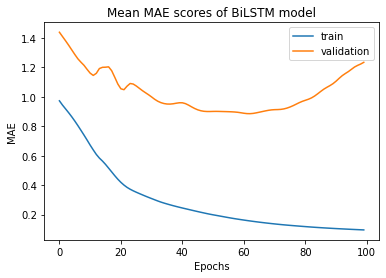

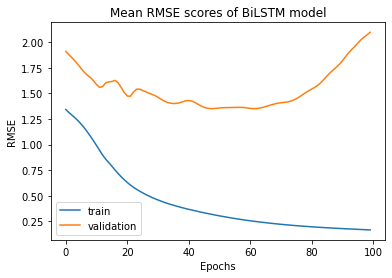

In [40]:
# results_rak
visualize_performance(results_rak)

Optimal Mean MAE: 0.7327585905790329 @ epoch 99
Optimal Mean RMSE: 1.1691561400890351 @ epoch 99


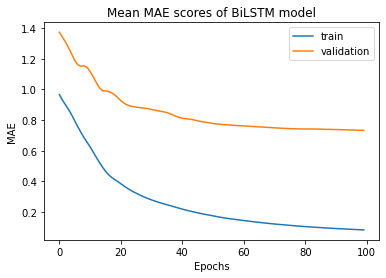

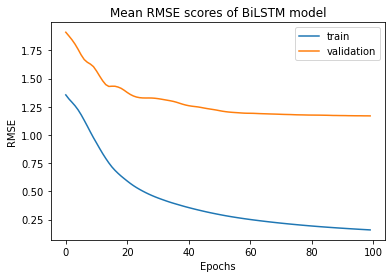

In [41]:
visualize_performance(results_wall)

Optimal Mean MAE: 0.7224365472793579 @ epoch 95
Optimal Mean RMSE: 1.2187684774398804 @ epoch 93


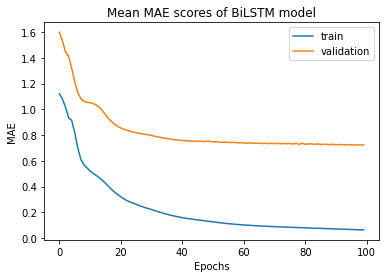

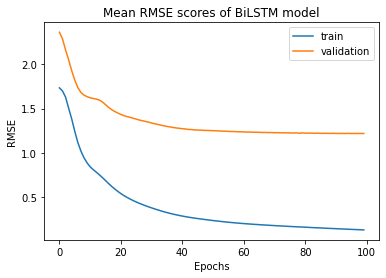

In [45]:
visualize_performance(results_total[1])

### Tacheometry Only

In [ ]:
results_tcmt_x = train_objects(train_Yx, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=False, tacheometry=True)
results_tcmt_y = train_objects(train_Yy, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=False, tacheometry=True)
results_tcmt_z = train_objects(train_Yz, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=False, tacheometry=True)

In [141]:
print('RMSE', 'MAE', 'MASE', 'R^2')
print(val_metrics('X', results_tcmt_x[0], 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False))
print(val_metrics('Y', results_tcmt_y[0], 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False))
print(val_metrics('Z', results_tcmt_z[0], 10, 5, 1, incl_cpt=False, incl_sat=False, tacheometry=True, incremental=False))

RMSE MAE MASE R^2
(1.1123464, 0.7910220931373606, 0.46241750071163273, -98.94533842875592)
(1.2415555, 0.9062942200515177, 0.39947965419665343, -203.43262710659315)
(1.0938284, 0.7822483829758522, 0.46088119818515877, -101.85569989344853)


In [ ]:
# Run only if model should be saved AND written over on disk

save_models(results_tcmt_x, 'TCMT', 'X')
save_models(results_tcmt_y, 'TCMT', 'Y')
save_models(results_tcmt_z, 'TCMT', 'Z')

### Tacheometry + CPT

In [42]:
results_tcmt_cpt_x = train_objects(train_Yx, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=True, tacheometry=True)
results_tcmt_cpt_y = train_objects(train_Yy, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=True, tacheometry=True)
results_tcmt_cpt_z = train_objects(train_Yz, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=True, tacheometry=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:51<00:00,  5.58s/it]


In [43]:
print(val_metrics('X', results_tcmt_cpt_x[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=False))
print(val_metrics('Y', results_tcmt_cpt_y[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=False))
print(val_metrics('Z', results_tcmt_cpt_z[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=False))

(1.079717, 0.7690374010709731, 0.45759626143273396, -147.38229360916685)
(1.2133859, 0.8794474722176234, 0.38455018794810086, -189.93629028742072)
(1.0781837, 0.7685083161720458, 0.4537022831485917, -81.17139777480223)


In [ ]:
save_models(results_tcmt_cpt_x, 'TCMT_CPT', 'X')
save_models(results_tcmt_cpt_y, 'TCMT_CPT', 'Y')
save_models(results_tcmt_cpt_z, 'TCMT_CPT', 'Z')

### CPT Only

In [40]:
results_cpt_x = train_objects(df=train_Yx, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=True, tacheometry=False)
results_cpt_y = train_objects(df=train_Yy, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=True, tacheometry=False)
results_cpt_z = train_objects(df=train_Yz, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=True, tacheometry=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:56<00:00,  5.84s/it]


In [41]:
print(val_metrics('X', results_cpt_x[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=False, incremental=False))
print(val_metrics('Y', results_cpt_y[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=False, incremental=False))
print(val_metrics('Z', results_cpt_z[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=False, incremental=False))

(1.2007326, 0.8894597393263377, 0.5194469003005332, -55.12418584640358)
(1.3684523, 1.0026749408437834, 0.42979171496001467, -104.00207470702344)
(1.2033317, 0.8911757830395732, 0.5206260647003387, -46.77106554815651)


In [ ]:
save_models(results_cpt_x, 'CPT', 'X')
save_models(results_cpt_y, 'CPT', 'Y')
save_models(results_cpt_z, 'CPT', 'Z')

### Tacheometry + Satellite

In [61]:
results_tcmt_sat_x = train_objects(train_Yx, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=False, tacheometry=True, incl_sat=True)
results_tcmt_sat_y = train_objects(train_Yy, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=False, tacheometry=True, incl_sat=True)
results_tcmt_sat_z = train_objects(train_Yz, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=False, tacheometry=True, incl_sat=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:20<00:00,  7.02s/it]


In [ ]:
# mean sat
(1.0899403, 0.7853048451211988, 0.4672808486119302, -186.41611210120135)
(1.1782153, 0.8425265915392283, 0.37742732318565236, -186.864965175712)
(1.0714349, 0.7650132613358018, 0.4520611819197759, -95.91826823843361)

# different time series for each direction
(1.167556, 0.8728575300421998, 0.536836693515254, -337.8655388208417)
(1.2435288, 0.932855880636086, 0.44200158305095477, -370.6174862375467)
(1.198489, 0.8946519199655766, 0.5481434827595083, -389.3761095577384)

In [65]:
print(val_metrics('X', results_tcmt_sat_x[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=False))
print(val_metrics('Y', results_tcmt_sat_y[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=False))
print(val_metrics('Z', results_tcmt_sat_z[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=False))

(1.0759361, 0.7695640892610401, 0.4667609228961605, -128.2736715847969)
(1.2175939, 0.8787708310145117, 0.3869327622528927, -211.43315100909967)
(1.0718968, 0.7794821504235587, 0.46300694276848764, -154.62037793741382)


In [ ]:
save_models(results_tcmt_sat_x, 'TCMT_SAT', 'X')
save_models(results_tcmt_sat_y, 'TCMT_SAT', 'Y')
save_models(results_tcmt_sat_z, 'TCMT_SAT', 'Z')

### Satellite Only

In [49]:
results_sat_x = train_objects(train_Yx, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=False, tacheometry=False, incl_sat=True)
results_sat_y = train_objects(train_Yy, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=False, tacheometry=False, incl_sat=True)
results_sat_z = train_objects(train_Yz, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=False, tacheometry=False, incl_sat=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:41<00:00,  5.05s/it]


In [50]:
print(val_metrics('X', results_sat_x[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=False, incremental=False))
print(val_metrics('Y', results_sat_y[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=False, incremental=False))
print(val_metrics('Z', results_sat_z[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=False, incremental=False))

(1.0891328, 0.7817181391138291, 0.47379700478226494, -125.38159255306672)
(1.198049, 0.8553617536854036, 0.3730054145426475, -233.15624342713335)
(1.127131, 0.8090382617158014, 0.49006679755230326, -112.85932987887944)


In [ ]:
save_models(results_sat_x, 'SAT', 'X')
save_models(results_sat_y, 'SAT', 'Y')
save_models(results_sat_z, 'SAT', 'Z')

### Satellite <- CPT (incremental)

In [40]:
results_inc_sat_cpt_x = incremental_fusion('Sat', 'X')
results_inc_sat_cpt_y = incremental_fusion('Sat', 'Y')
results_inc_sat_cpt_z = incremental_fusion('Sat', 'Z')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:15<00:00, 21.79s/it]


In [41]:
print(val_metrics('X', results_inc_sat_cpt_x[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=False, incremental=True, incremental_first='Sat'))
print(val_metrics('Y', results_inc_sat_cpt_y[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=False, incremental=True, incremental_first='Sat'))
print(val_metrics('Z', results_inc_sat_cpt_z[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=False, incremental=True, incremental_first='Sat'))

(1.1396741, 0.8087201378477987, 0.472999548847005, -47.59166928335976)
(1.1733396, 0.8454092941997308, 0.3707709720068019, -39.58811461976282)
(1.1182802, 0.7879284501864934, 0.4591222868717568, -49.75194787332953)


In [ ]:
save_models(results_inc_sat_cpt_x, 'INC_SAT_CPT', 'X')
save_models(results_inc_sat_cpt_y, 'INC_SAT_CPT', 'Y')
save_models(results_inc_sat_cpt_z, 'INC_SAT_CPT', 'Z')

### Tacheometry + Satellite <- CPT (incremental)

In [40]:
results_inc_tcmt_sat_cpt_x = incremental_fusion('Sat', 'X', tacheometry=True)
results_inc_tcmt_sat_cpt_y = incremental_fusion('Sat', 'Y', tacheometry=True)
results_inc_tcmt_sat_cpt_z = incremental_fusion('Sat', 'Z', tacheometry=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:47<00:00,  8.36s/it]


In [41]:
print(val_metrics('X', results_inc_tcmt_sat_cpt_x[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat'))
print(val_metrics('Y', results_inc_tcmt_sat_cpt_y[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat'))
print(val_metrics('Z', results_inc_tcmt_sat_cpt_z[0], 10, 5, 1, incl_cpt=False, incl_sat=True, tacheometry=True, incremental=True, incremental_first='Sat'))

(1.0280902, 0.7139260742469816, 0.4189984431285839, -26.922550389280197)
(1.0541695, 0.7415452627295276, 0.31320062420013284, -20.936573029903535)
(1.0415981, 0.73136428740907, 0.43158583357207886, -33.63053353374167)


In [ ]:
save_models(results_inc_tcmt_sat_cpt_x, 'INC_TCMT_SAT_CPT', 'X')
save_models(results_inc_tcmt_sat_cpt_y, 'INC_TCMT_SAT_CPT', 'Y')
save_models(results_inc_tcmt_sat_cpt_z, 'INC_TCMT_SAT_CPT', 'Z')

### CPT <- Satellite (incremental)

In [40]:
results_inc_cpt_sat_x = incremental_fusion('CPT', 'X')
results_inc_cpt_sat_y = incremental_fusion('CPT', 'Y')
results_inc_cpt_sat_z = incremental_fusion('CPT', 'Z')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:10<00:00, 21.53s/it]


In [41]:
print(val_metrics('X', results_inc_cpt_sat_x[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=False, incremental=True, incremental_first='CPT'))
print(val_metrics('Y', results_inc_cpt_sat_y[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=False, incremental=True, incremental_first='CPT'))
print(val_metrics('Z', results_inc_cpt_sat_z[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=False, incremental=True, incremental_first='CPT'))

(1.1304348, 0.8114228990853862, 0.4744135062534095, -53.68312422185485)
(1.1379614, 0.8154828616924892, 0.3573341103391451, -45.43225253681015)
(1.1246732, 0.8081005400681753, 0.4746364720724304, -64.37888416388918)


In [ ]:
save_models(results_inc_cpt_sat_x, 'INC_CPT_SAT', 'X')
save_models(results_inc_cpt_sat_y, 'INC_CPT_SAT', 'Y')
save_models(results_inc_cpt_sat_z, 'INC_CPT_SAT', 'Z')

### Tacheometry + CPT <- Satellite (incremental)

In [40]:
results_inc_tcmt_cpt_sat_x = incremental_fusion('CPT', 'X', tacheometry=True)
results_inc_tcmt_cpt_sat_y = incremental_fusion('CPT', 'Y', tacheometry=True)
results_inc_tcmt_cpt_sat_z = incremental_fusion('CPT', 'Z', tacheometry=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:47<00:00,  8.38s/it]


In [42]:
print(val_metrics('X', results_inc_tcmt_cpt_sat_x[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=True, incremental_first='CPT'))
print(val_metrics('Y', results_inc_tcmt_cpt_sat_y[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=True, incremental_first='CPT'))
print(val_metrics('Z', results_inc_tcmt_cpt_sat_z[0], 10, 5, 1, incl_cpt=True, incl_sat=False, tacheometry=True, incremental=True, incremental_first='CPT'))

(1.0469167, 0.7395422620252023, 0.43524892036906637, -36.069896806291204)
(1.0426397, 0.7336318293896588, 0.3177306102647406, -47.380980906622355)
(1.039767, 0.7337450801774674, 0.4310670621735876, -35.633977582030795)


In [ ]:
save_models(results_inc_tcmt_cpt_sat_x, 'INC_TCMT_CPT_SAT', 'X')
save_models(results_inc_tcmt_cpt_sat_y, 'INC_TCMT_CPT_SAT', 'Y')
save_models(results_inc_tcmt_cpt_sat_z, 'INC_TCMT_CPT_SAT', 'Z')

### Tacheometry + CPT + Satellite

In [40]:
results_tcmt_cpt_sat_x = train_objects(train_Yx, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=True, tacheometry=True, incl_sat=True)
results_tcmt_cpt_sat_y = train_objects(train_Yy, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=True, tacheometry=True, incl_sat=True)
results_tcmt_cpt_sat_z = train_objects(train_Yz, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=True, tacheometry=True, incl_sat=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:01<00:00,  6.07s/it]


In [41]:
print(val_metrics('X', results_tcmt_cpt_sat_x[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=True, incremental=False))
print(val_metrics('Y', results_tcmt_cpt_sat_y[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=True, incremental=False))
print(val_metrics('Z', results_tcmt_cpt_sat_z[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=True, incremental=False))

(1.064839, 0.7642070929557855, 0.458182156304324, -108.82370548789042)
(1.1807091, 0.8558405061917285, 0.38000676630155455, -213.14858136360334)
(1.072779, 0.7672759368704889, 0.46075788859976213, -129.8708472291498)


In [ ]:
save_models(results_tcmt_cpt_sat_x, 'TCMT_CPT_SAT', 'X')
save_models(results_tcmt_cpt_sat_y, 'TCMT_CPT_SAT', 'Y')
save_models(results_tcmt_cpt_sat_z, 'TCMT_CPT_SAT', 'Z')

### CPT + Satellite

In [40]:
results_cpt_sat_x = train_objects(train_Yx, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=True, tacheometry=False, incl_sat=True)
results_cpt_sat_y = train_objects(train_Yy, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=True, tacheometry=False, incl_sat=True)
results_cpt_sat_z = train_objects(train_Yz, input_width=10, label_width=5, shift=1, epochs=100, incl_cpt=True, tacheometry=False, incl_sat=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:23<00:00, 10.20s/it]


In [41]:
print(val_metrics('X', results_cpt_sat_x[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=False, incremental=False))
print(val_metrics('Y', results_cpt_sat_y[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=False, incremental=False))
print(val_metrics('Z', results_cpt_sat_z[0], 10, 5, 1, incl_cpt=True, incl_sat=True, tacheometry=False, incremental=False))

(1.1249307, 0.8033167219767303, 0.48366546009451994, -110.58584128139839)
(1.1770685, 0.8586639674056104, 0.3767699439359974, -263.4586832236406)
(1.1085229, 0.791343165099051, 0.48047803076502715, -108.21871370577078)


In [ ]:
save_models(results_cpt_sat_x, 'CPT_SAT', 'X')
save_models(results_cpt_sat_y, 'CPT_SAT', 'Y')
save_models(results_cpt_sat_z, 'CPT_SAT', 'Z')

### Aggregate CPT / Satellite (late fusion)

In [41]:
results_cpt_x = [load_models('CPT', 'X')]
results_cpt_y = [load_models('CPT', 'Y')]
results_cpt_z = [load_models('CPT', 'Z')]

results_sat_x = [load_models('SAT', 'X')]
results_sat_y = [load_models('SAT', 'Y')]
results_sat_z = [load_models('SAT', 'Z')]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:35<00:00,  1.79s/it]


In [51]:
print(late_fusion(direction='X', tacheometry=False, incremental=False))
print(late_fusion(direction='Y', tacheometry=False, incremental=False))
print(late_fusion(direction='Z', tacheometry=False, incremental=False))

(1.1042538, 0.8030500185192617, 0.4753667516908767)
(1.2182729, 0.8827686904743551, 0.3796767384731564)
(1.129487, 0.8212235466237147, 0.48698521091633856)


### Aggregate TCMT + CPT / TCMT + Satellite (late fusion)

In [ ]:
results_tcmt_cpt_x = [load_models('TCMT_CPT', 'X')]
results_tcmt_cpt_y = [load_models('TCMT_CPT', 'Y')]
results_tcmt_cpt_z = [load_models('TCMT_CPT', 'Z')]

results_tcmt_sat_x = [load_models('TCMT_SAT', 'X')]
results_tcmt_sat_y = [load_models('TCMT_SAT', 'Y')]
results_tcmt_sat_z = [load_models('TCMT_SAT', 'Z')]

In [ ]:
print(late_fusion(direction='X', tacheometry=True, incremental=False))
print(late_fusion(direction='Y', tacheometry=True, incremental=False))
print(late_fusion(direction='Z', tacheometry=True, incremental=False))

### Aggregate CPT <- Satellite / Satellite <- CPT (late fusion)

In [ ]:
results_inc_cpt_sat_x = [load_models('INC_CPT_SAT', 'X')]
results_inc_cpt_sat_y = [load_models('INC_CPT_SAT', 'Y')]
results_inc_cpt_sat_z = [load_models('INC_CPT_SAT', 'Z')]

results_inc_sat_cpt_x = [load_models('INC_SAT_CPT', 'X')]
results_inc_sat_cpt_y = [load_models('INC_SAT_CPT', 'Y')]
results_inc_sat_cpt_z = [load_models('INC_SAT_CPT', 'Z')]

In [ ]:
print(late_fusion(direction='X', tacheometry=False, incremental=True))
print(late_fusion(direction='Y', tacheometry=False, incremental=True))
print(late_fusion(direction='Z', tacheometry=False, incremental=True))

### Aggregate TCMT + CPT <- Satellite / TCMT + Satellite <- CPT (late fusion)

In [ ]:
results_inc_tcmt_cpt_sat_x = [load_models('INC_TCMT_CPT_SAT', 'X')]
results_inc_tcmt_cpt_sat_y = [load_models('INC_TCMT_CPT_SAT', 'Y')]
results_inc_tcmt_cpt_sat_z = [load_models('INC_TCMT_CPT_SAT', 'Z')]

results_inc_tcmt_sat_cpt_x = [load_models('INC_TCMT_SAT_CPT', 'X')]
results_inc_tcmt_sat_cpt_y = [load_models('INC_TCMT_SAT_CPT', 'Y')]
results_inc_tcmt_sat_cpt_z = [load_models('INC_TCMT_SAT_CPT', 'Z')]

In [46]:
print(late_fusion(direction='X', tacheometry=True, incremental=True))
print(late_fusion(direction='Y', tacheometry=True, incremental=True))
print(late_fusion(direction='Z', tacheometry=True, incremental=True))

(1.0321076, 0.7231472958672182, 0.42236383669356947)
(1.0097909, 0.7027154133716801, 0.3033248562950376)
(1.0166171, 0.7128378072706564, 0.41419585343476806)


### Naive Baseline

In [83]:
results_naive = train_objects(train_Yx, input_width=10, label_width=5, shift=1, model='naive', incl_cpt=False, tacheometry=True)
results_naive = np.array(results_naive[1])
rmse_naive = results_naive[:,0]
mae_naive = results_naive[:,1]
mase_naive = results_naive[:,2]
print(f'Baseline Naive Method RMSE = {np.mean(rmse_naive)}')
print(f'Baseline Naive Method MAE = {np.mean(mae_naive)}')
print(f'Baseline Naive Method MASE = {np.mean(mase_naive)}')

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.14it/s]

Baseline Naive Method RMSE = 1.2479587481526846
Baseline Naive Method MAE = 1.186652454193377
Baseline Naive Method MASE = 0.853035866979823


In [84]:
results_naive = train_objects(train_Yy, input_width=10, label_width=5, shift=1, model='naive', incl_cpt=False, tacheometry=True)
results_naive = np.array(results_naive[1])
rmse_naive = results_naive[:,0]
mae_naive = results_naive[:,1]
mase_naive = results_naive[:,2]
print(f'Baseline Naive Method RMSE = {np.mean(rmse_naive)}')
print(f'Baseline Naive Method MAE = {np.mean(mae_naive)}')
print(f'Baseline Naive Method MASE = {np.mean(mase_naive)}')

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.04it/s]

Baseline Naive Method RMSE = 1.7783279529708367
Baseline Naive Method MAE = 1.7019130578185302
Baseline Naive Method MASE = 1.0194687556301143


In [85]:
results_naive = train_objects(train_Yz, input_width=10, label_width=5, shift=1, model='naive', incl_cpt=False, tacheometry=True)
results_naive = np.array(results_naive[1])
rmse_naive = results_naive[:,0]
mae_naive = results_naive[:,1]
mase_naive = results_naive[:,2]
print(f'Baseline Naive Method RMSE = {np.mean(rmse_naive)}')
print(f'Baseline Naive Method MAE = {np.mean(mae_naive)}')
print(f'Baseline Naive Method MASE = {np.mean(mase_naive)}')

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 150.33it/s]

Baseline Naive Method RMSE = 1.2479587481526846
Baseline Naive Method MAE = 1.186652454193377
Baseline Naive Method MASE = 0.853035866979823


# Evaluation

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))

# create x axis labels
x_nums = [i for i in range(len(cpt.columns)+1) if i%4==0]
labels = list(['timeseries value']) + list(cpt.columns)

# plot weights
plt.bar(x=range(len(cpt.columns)+1), height=model.layers[0].get_weights()[0].mean(axis=1))
plt.xticks(x_nums, labels[::4], rotation=90)
plt.title('Mean Weights of BiLSTM models')

plt.show()